In [1]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [2]:
import glob
import pandas as pd
import cv2
import gc
import numpy as np
import random
import imageio
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from tensorflow_docs.vis import embed
import matplotlib.pyplot as plt

2025-06-19 22:06:23.671357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750370783.877935   12722 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750370783.937598   12722 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
class CFG:
    epochs = 50
    batch_size = 16
    classes = [
        "Action", "Animation", "Boxing", "Comedy", 
        "Drama", "Horror", "Music, Dance", "Racing", "Romance", "Scifi", "Sports"
    ]


In [4]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 24):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')

In [5]:
import glob

# Initialize lists to store file paths and labels
file_paths = []
targets = []



for i, cls in enumerate(CFG.classes):
    # Use glob to find all .avi files in the current split and class folder
    sub_file_paths = glob.glob(f"/kaggle/input/movie-short-dataset/New small movie dataset/{cls}/*.mp4")
    # Append the file paths and corresponding labels
    file_paths += sub_file_paths
    targets += [i] * len(sub_file_paths)

# Check the results
print(f"Total files found: {len(file_paths)}")
print(f"First 5 file paths: {file_paths[:5]}")
print(f"First 5 targets: {targets[:5]}")

Total files found: 1558
First 5 file paths: ['/kaggle/input/movie-short-dataset/New small movie dataset/Action/Action_JohnWick4_S_8 - 6of16.mp4', '/kaggle/input/movie-short-dataset/New small movie dataset/Action/Action_Black Panther_S_2 - 2of2.mp4', '/kaggle/input/movie-short-dataset/New small movie dataset/Action/Action_TheDarkKnight_S_4 - 4of6.mp4', '/kaggle/input/movie-short-dataset/New small movie dataset/Action/Action_JohnWick4_S_4 - 8of15.mp4', '/kaggle/input/movie-short-dataset/New small movie dataset/Action/Action_TheDarkKnight_S_5 - 1of7.mp4']
First 5 targets: [0, 0, 0, 0, 0]


In [6]:
print(CFG.classes)

['Action', 'Animation', 'Boxing', 'Comedy', 'Drama', 'Horror', 'Music, Dance', 'Racing', 'Romance', 'Scifi', 'Sports']


I0000 00:00:1750370791.779432   12722 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


(16, 224, 224, 3)



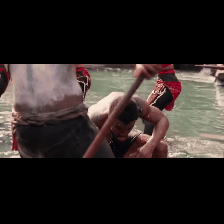

In [7]:
sample_video = frames_from_video_file(file_paths[1], n_frames = 16)
print(sample_video.shape)
to_gif(sample_video)

In [8]:
features = []
for file_path in tqdm(file_paths):
    features.append(frames_from_video_file(file_path, n_frames = 12))
features = np.array(features)

  0%|          | 0/1558 [00:00<?, ?it/s]

In [ ]:
from sklearn.model_selection import train_test_split
import torch

# First, split into train (80%) and temp (20%)
train_features, temp_features, train_targets, temp_targets = train_test_split(
    features, targets, test_size=0.2, random_state=42
)

# Then split temp into validation (10%) and test (10%)
val_features, test_features, val_targets, test_targets = train_test_split(
    temp_features, temp_targets, test_size=0.5, random_state=42
)

# Convert to PyTorch tensors
train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
train_targets_tensor = torch.tensor(train_targets, dtype=torch.long)

val_features_tensor = torch.tensor(val_features, dtype=torch.float32)
val_targets_tensor = torch.tensor(val_targets, dtype=torch.long)

test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
test_targets_tensor = torch.tensor(test_targets, dtype=torch.long)

# Print shapes to verify
print("Train features shape:", train_features_tensor.shape)
print("Validation features shape:", val_features_tensor.shape)
print("Test features shape:", test_features_tensor.shape)
print("Train targets length:", len(train_targets_tensor))
print("Validation targets length:", len(val_targets_tensor))
print("Test targets length:", len(test_targets_tensor))


In [14]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert data to PyTorch tensors
train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
train_targets_tensor = torch.tensor(train_targets, dtype=torch.long)

val_features_tensor = torch.tensor(val_features, dtype=torch.float32)
val_targets_tensor = torch.tensor(val_targets, dtype=torch.long)

# Create TensorDataset
train_dataset = TensorDataset(train_features_tensor, train_targets_tensor)
valid_dataset = TensorDataset(val_features_tensor, val_targets_tensor)
test_dataset = TensorDataset(val_features_tensor, val_targets_tensor)  # Same as valid_dataset

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=2, pin_memory=True)


In [15]:
del train_features
del val_features
gc.collect()

30

Processing Training set: 100%|██████████| 36/36 [00:04<00:00,  8.00it/s]



Training Set Class Distribution:
----------------------------------------
 Class  Count  Percentage
     0     49        8.69
     1     28        4.96
     2     23        4.08
     3     44        7.80
     4     70       12.41
     5     42        7.45
     6     57       10.11
     7     33        5.85
     8    125       22.16
     9     49        8.69
    10     44        7.80
----------------------------------------
Total samples: 564
Classes: 11


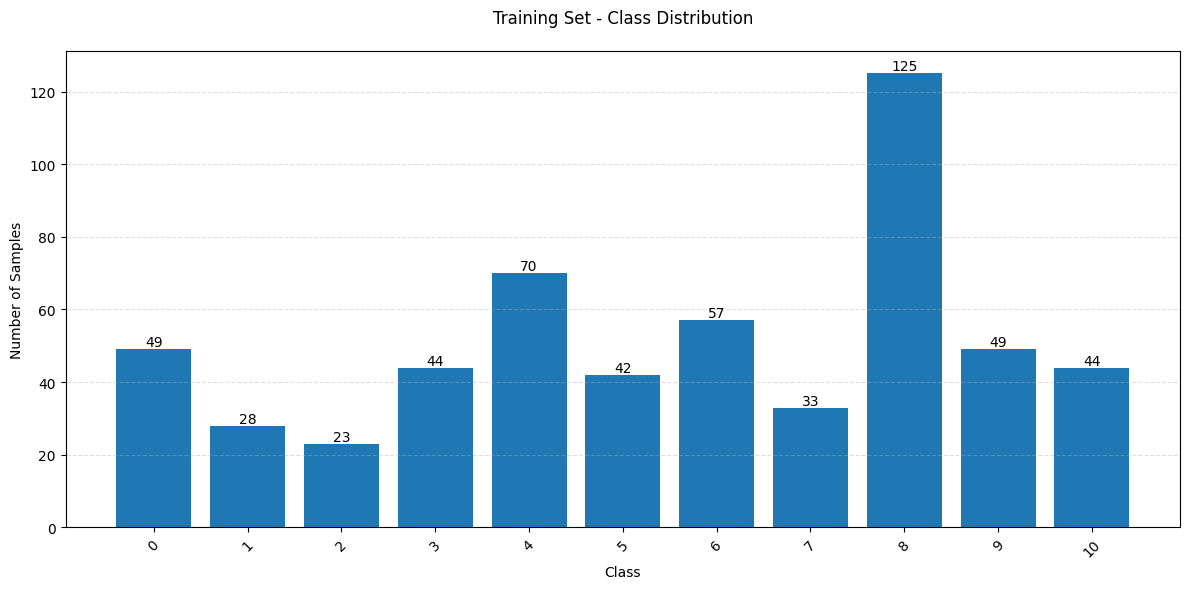

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

def show_class_counts(loader, dataset_name="Training"):
    # Collect all labels
    all_labels = []
    for _, labels in tqdm(loader, desc=f"Processing {dataset_name} set"):
        all_labels.extend(labels.numpy())
    
    # Count class occurrences
    class_counts = Counter(all_labels)
    sorted_counts = sorted(class_counts.items())
    
    # Create DataFrame for nice display
    df = pd.DataFrame(sorted_counts, columns=['Class', 'Count'])
    df['Percentage'] = (df['Count'] / df['Count'].sum() * 100).round(2)
    
    # Display table
    print(f"\n{dataset_name} Set Class Distribution:")
    print("-" * 40)
    print(df.to_string(index=False))
    print("-" * 40)
    print(f"Total samples: {df['Count'].sum()}")
    print(f"Classes: {len(df)}")
    
    # Plot distribution
    plt.figure(figsize=(12, 6))
    bars = plt.bar(df['Class'].astype(str), df['Count'])
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,}',
                ha='center', va='bottom')
    
    plt.title(f'{dataset_name} Set - Class Distribution', pad=20)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()
    
    return df

# Show training set counts
train_counts = show_class_counts(train_loader, "Training")

# If you want to check validation set as well:
# valid_counts = show_class_counts(valid_loader, "Validation")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchvision.models import resnet18

# --- Label Smoothing ---
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.kl_div = nn.KLDivLoss(reduction='batchmean')

    def forward(self, pred, target):
        pred = torch.log_softmax(pred, dim=-1)
        true_dist = torch.zeros_like(pred)
        true_dist.fill_(self.smoothing / (self.cls - 1))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return self.kl_div(pred, true_dist)

# --- Diffusion Encoder (ResNet as placeholder) ---
class DiffusionEncoder(nn.Module):
    def __init__(self):
        super(DiffusionEncoder, self).__init__()
        base_model = resnet18(pretrained=True)
        self.encoder = nn.Sequential(*list(base_model.children())[:-1])  # remove classifier
        self.output_dim = base_model.fc.in_features

    def forward(self, x):
        return self.encoder(x).view(x.size(0), -1)

# --- Physics-Informed PINN Classifier ---
class PINNClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(PINNClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.act = nn.Tanh()
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        return self.output(x)

    def physics_loss(self, feats):
        if not feats.requires_grad:
            return torch.tensor(0.0, device=feats.device)
        grad = torch.autograd.grad(feats.sum(), feats, create_graph=True)[0]
        loss = (grad ** 2).mean()
        return loss

# --- Final Model ---
class DiffusionPINNModel(nn.Module):
    def __init__(self, num_classes):
        super(DiffusionPINNModel, self).__init__()
        self.encoder = DiffusionEncoder()
        self.classifier = PINNClassifier(self.encoder.output_dim, num_classes)

    def forward(self, x, require_grad=False):
        B, T, H, W, C = x.shape
        x = x.view(B * T, H, W, C).permute(0, 3, 1, 2)  # (B*T, C, H, W)
        feats = self.encoder(x)  # (B*T, feat_dim)
        feats = feats.view(B, T, -1).mean(dim=1)
        if require_grad:
            feats = feats.requires_grad_()
        logits = self.classifier(feats)
        return logits, feats

    def total_loss(self, output, target, features, criterion, lambda_phys=0.01):
        ce_loss = criterion(output, target)
        phys_loss = self.classifier.physics_loss(features)
        return ce_loss + lambda_phys * phys_loss

# --- Setup ---
num_classes = 11
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DiffusionPINNModel(num_classes).to(device)
criterion = LabelSmoothingLoss(classes=num_classes, smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Use GradScaler only if CUDA is available
scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

# --- Early Stopping ---
patience = 3
best_val_loss = float('inf')
early_stop_counter = 0
train_accuracies, val_accuracies, train_losses, val_losses = [], [], [], []

# --- Training Loop ---
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        if scaler is not None:
            with torch.cuda.amp.autocast():
                out, feats = model(x, require_grad=True)
                loss = model.total_loss(out, y, feats, criterion)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            out, feats = model(x, require_grad=True)
            loss = model.total_loss(out, y, feats, criterion)
            loss.backward()
            optimizer.step()

        running_train_loss += loss.item() * x.size(0)
        _, pred = out.max(1)
        total_train += y.size(0)
        correct_train += (pred == y).sum().item()

    avg_train_loss = running_train_loss / len(train_loader.dataset)
    train_accuracy = 100. * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # --- Validation ---
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for x, y in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]"):
            x, y = x.to(device), y.to(device)
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    out, _ = model(x, require_grad=False)
                    loss = criterion(out, y)  # Only classification loss for validation
            else:
                out, _ = model(x, require_grad=False)
                loss = criterion(out, y)

            running_val_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            total_val += y.size(0)
            correct_val += (pred == y).sum().item()

    avg_val_loss = running_val_loss / len(valid_loader.dataset)
    val_accuracy = 100. * correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

# --- Plotting ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='x')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc', marker='o')
plt.plot(val_accuracies, label='Val Acc', marker='x')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

VGG-19

In [16]:
import torch
import torch.nn as nn
from torchvision import models

# VGG19 + LSTM model definition
class VGG19_LSTM(nn.Module):
    def __init__(self, num_classes, hidden_dim=256, num_layers=1):
        super(VGG19_LSTM, self).__init__()

        # Load pretrained VGG-19
        vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
        self.vgg_features = vgg.features
        self.avgpool = vgg.avgpool
        self.flatten = nn.Flatten()
        self.feature_dim = 512 * 7 * 7  # Output from avgpool is (512, 7, 7)

        # LSTM for temporal modeling
        self.lstm = nn.LSTM(input_size=self.feature_dim, hidden_size=hidden_dim,
                            num_layers=num_layers, batch_first=True)

        # Final classification layer
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x: [B, T, C, H, W] or possibly [B, T, H, W, C]
        if x.shape[-1] == 3:  # handle NHWC case
            x = x.permute(0, 1, 4, 2, 3)  # → [B, T, C, H, W]
        
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)  # [B*T, C, H, W]
    
        with torch.no_grad():
            x = self.vgg_features(x)
            x = self.avgpool(x)
    
        x = self.flatten(x)          # [B*T, F]
        x = x.view(B, T, -1)         # [B, T, F]
        lstm_out, _ = self.lstm(x)   # [B, T, hidden]
        out = self.classifier(lstm_out[:, -1, :])
        return out


# Configuration
num_classes = 11
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VGG19_LSTM(num_classes).to(device)

# Dummy input and labels
x = torch.randn((16, 16, 3, 224, 224)).to(device)  # [Batch, Time, C, H, W]
y = torch.randint(0, num_classes, (16,)).to(device)  # [Batch]

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scaler = torch.cuda.amp.GradScaler()  # Mixed precision scaler

# Forward pass with mixed precision
with torch.amp.autocast(device_type='cuda'):
    output = model(x)
    print("Output shape:", output.shape)
    loss = criterion(output, y)
    print("Loss:", loss.item())

# Backpropagation
optimizer.zero_grad()
scaler.scale(loss).backward()
scaler.step(optimizer)
scaler.update()


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 218MB/s] 
/tmp/ipykernel_35/893576814.py:56: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Mixed precision scaler


Output shape: torch.Size([16, 11])
Loss: 2.400634765625


/tmp/ipykernel_35/1314067124.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]/tmp/ipykernel_35/1314067124.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 [Valid]:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_35/1314067124.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 [Valid]: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Epoch 1 | Train Loss: 2.1844 | Train Acc: 25.53% | Val Loss: 2.1130 | Val Acc: 23.94%


Epoch 2/50 [Valid]: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Epoch 2 | Train Loss: 1.5086 | Train Acc: 61.88% | Val Loss: 1.8630 | Val Acc: 32.39%


Epoch 3/50 [Valid]: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch 3 | Train Loss: 1.0186 | Train Acc: 85.28% | Val Loss: 1.7183 | Val Acc: 42.25%


Epoch 4/50 [Valid]: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch 4 | Train Loss: 0.6490 | Train Acc: 93.79% | Val Loss: 1.6716 | Val Acc: 43.66%


Epoch 5/50 [Valid]: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Epoch 5 | Train Loss: 0.4163 | Train Acc: 97.16% | Val Loss: 1.5677 | Val Acc: 46.48%


Epoch 6/50 [Valid]: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch 6 | Train Loss: 0.2649 | Train Acc: 98.94% | Val Loss: 1.5385 | Val Acc: 47.89%


Epoch 7/50 [Valid]: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch 7 | Train Loss: 0.1783 | Train Acc: 99.47% | Val Loss: 1.5222 | Val Acc: 49.30%


Epoch 8/50 [Valid]: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch 8 | Train Loss: 0.1273 | Train Acc: 99.47% | Val Loss: 1.5092 | Val Acc: 53.52%


Epoch 9/50 [Valid]: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch 9 | Train Loss: 0.0944 | Train Acc: 99.82% | Val Loss: 1.4757 | Val Acc: 50.70%


Epoch 10/50 [Valid]: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Epoch 10 | Train Loss: 0.0723 | Train Acc: 99.82% | Val Loss: 1.4476 | Val Acc: 53.52%


Epoch 11/50 [Valid]: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch 11 | Train Loss: 0.0580 | Train Acc: 100.00% | Val Loss: 1.4623 | Val Acc: 54.93%


Epoch 12/50 [Valid]: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch 12 | Train Loss: 0.0474 | Train Acc: 100.00% | Val Loss: 1.4674 | Val Acc: 54.93%


Epoch 13/50 [Valid]: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Epoch 13 | Train Loss: 0.0400 | Train Acc: 100.00% | Val Loss: 1.4735 | Val Acc: 53.52%
Early stopping triggered.


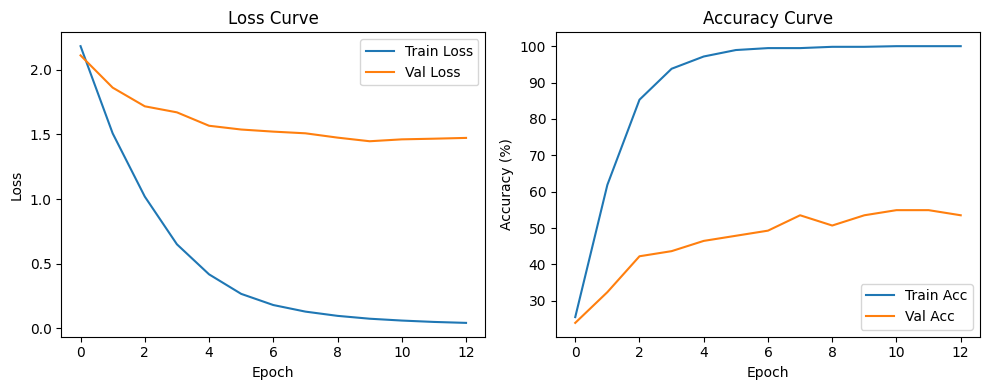

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import os

# Define your model before using it here
# from your_model_file import VGG19_LSTM

# Setup
num_classes = 11
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VGG19_LSTM(num_classes=num_classes).to(device)

# Loss, optimizer, scheduler
class_weights = torch.tensor([1.0] * num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Mixed Precision
scaler = torch.cuda.amp.GradScaler()

# Early stopping
patience = 3
best_val_loss = float('inf')
early_stop_counter = 0

# Tracking
history = {
    'train_loss': [],
    'val_loss': [],
    'train_accuracy': [],
    'val_accuracy': []
}

# Dataloaders (You must define `train_loader` and `valid_loader` before this)
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()

        torch.cuda.empty_cache()

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * train_correct / train_total
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, targets in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]"):
            inputs = inputs.to(device)
            targets = targets.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

            torch.cuda.empty_cache()

    val_loss /= len(valid_loader.dataset)
    val_accuracy = 100. * val_correct / val_total
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "vgg19_model.pth")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

# Save training history as a .pt file
torch.save(history, "training_history_vgg19.pt")

# Optionally, save as CSV
df_history = pd.DataFrame(history)
df_history.to_csv("training_history_vgg19.csv", index=False)

# Plotting results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_accuracy'], label='Train Acc')
plt.plot(history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()


Generating Confusion Matrix:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_35/3186510639.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Generating Confusion Matrix: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


<Figure size 1000x800 with 0 Axes>

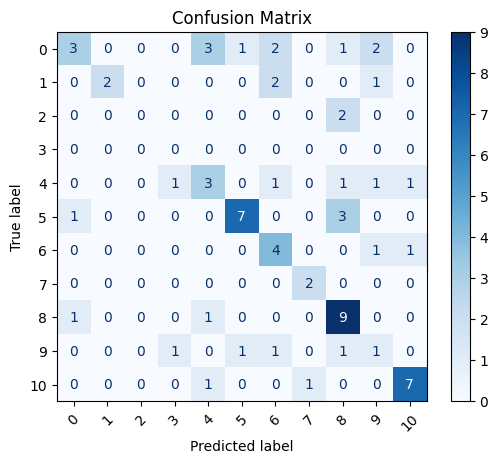

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Load best model
model.load_state_dict(torch.load("/kaggle/working/vgg19_model.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(valid_loader, desc="Generating Confusion Matrix"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(num_classes)])

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [20]:
import torch
import torch.nn as nn
from torchvision import models

# DenseNet121 + LSTM model definition
class DenseNet121_LSTM(nn.Module):
    def __init__(self, num_classes, hidden_dim=256, num_layers=1):
        super(DenseNet121_LSTM, self).__init__()

        # Load pretrained DenseNet121
        densenet = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        self.features = densenet.features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Adaptive pooling to get fixed size

        # Output feature dimension after global pooling
        self.feature_dim = 1024  # DenseNet121 output channels

        # LSTM for temporal modeling
        self.lstm = nn.LSTM(input_size=self.feature_dim, hidden_size=hidden_dim,
                            num_layers=num_layers, batch_first=True)

        # Final classification layer
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x: [B, T, C, H, W] or possibly [B, T, H, W, C]
        if x.shape[-1] == 3:  # handle NHWC case
            x = x.permute(0, 1, 4, 2, 3)  # → [B, T, C, H, W]
        
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)  # [B*T, C, H, W]

        with torch.no_grad():
            x = self.features(x)           # [B*T, 1024, H', W']
            x = self.avgpool(x)            # [B*T, 1024, 1, 1]

        x = x.view(B, T, -1)               # [B, T, 1024]
        lstm_out, _ = self.lstm(x)         # [B, T, hidden_dim]
        out = self.classifier(lstm_out[:, -1, :])  # Use the last time step
        return out


# Configuration
num_classes = 11
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DenseNet121_LSTM(num_classes).to(device)

# Dummy input and labels
x = torch.randn((16, 16, 3, 224, 224)).to(device)  # [Batch, Time, C, H, W]
y = torch.randint(0, num_classes, (16,)).to(device)  # [Batch]

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scaler = torch.cuda.amp.GradScaler()  # Mixed precision scaler

# Forward pass with mixed precision
with torch.amp.autocast(device_type='cuda'):
    output = model(x)
    print("Output shape:", output.shape)
    loss = criterion(output, y)
    print("Loss:", loss.item())

# Backpropagation
optimizer.zero_grad()
scaler.scale(loss).backward()
scaler.step(optimizer)
scaler.update()


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 207MB/s]
/tmp/ipykernel_35/1906284342.py:56: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Mixed precision scaler


Output shape: torch.Size([16, 11])
Loss: 2.39013671875


/tmp/ipykernel_35/1303376343.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]/tmp/ipykernel_35/1303376343.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 [Valid]:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_35/1303376343.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 1 | Train Loss: 2.2990 | Train Acc: 23.05% | Val Loss: 2.2583 | Val Acc: 21.13%


Epoch 2/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 2 | Train Loss: 2.0584 | Train Acc: 35.82% | Val Loss: 2.1276 | Val Acc: 29.58%


Epoch 3/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 3 | Train Loss: 1.8028 | Train Acc: 46.63% | Val Loss: 1.9573 | Val Acc: 29.58%


Epoch 4/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 4 | Train Loss: 1.5279 | Train Acc: 55.67% | Val Loss: 1.7980 | Val Acc: 35.21%


Epoch 5/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 5 | Train Loss: 1.2917 | Train Acc: 63.12% | Val Loss: 1.6384 | Val Acc: 43.66%


Epoch 6/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 6 | Train Loss: 1.0675 | Train Acc: 71.28% | Val Loss: 1.5395 | Val Acc: 46.48%


Epoch 7/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 7 | Train Loss: 0.8911 | Train Acc: 79.08% | Val Loss: 1.4706 | Val Acc: 50.70%


Epoch 8/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 8 | Train Loss: 0.7484 | Train Acc: 84.93% | Val Loss: 1.3724 | Val Acc: 53.52%


Epoch 9/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 9 | Train Loss: 0.6392 | Train Acc: 87.59% | Val Loss: 1.3617 | Val Acc: 54.93%


Epoch 10/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 10 | Train Loss: 0.5225 | Train Acc: 91.84% | Val Loss: 1.3340 | Val Acc: 54.93%


Epoch 11/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 11 | Train Loss: 0.4826 | Train Acc: 91.84% | Val Loss: 1.3100 | Val Acc: 53.52%


Epoch 12/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 12 | Train Loss: 0.4141 | Train Acc: 93.44% | Val Loss: 1.2912 | Val Acc: 59.15%


Epoch 13/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 13 | Train Loss: 0.3118 | Train Acc: 96.63% | Val Loss: 1.3032 | Val Acc: 56.34%


Epoch 14/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 14 | Train Loss: 0.2799 | Train Acc: 96.99% | Val Loss: 1.3705 | Val Acc: 53.52%


Epoch 15/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 15 | Train Loss: 0.2512 | Train Acc: 97.52% | Val Loss: 1.2804 | Val Acc: 54.93%


Epoch 16/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 16 | Train Loss: 0.2167 | Train Acc: 98.23% | Val Loss: 1.2425 | Val Acc: 54.93%


Epoch 17/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 17 | Train Loss: 0.1762 | Train Acc: 98.76% | Val Loss: 1.2368 | Val Acc: 59.15%


Epoch 18/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 18 | Train Loss: 0.1728 | Train Acc: 98.76% | Val Loss: 1.2720 | Val Acc: 57.75%


Epoch 19/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 19 | Train Loss: 0.1651 | Train Acc: 98.40% | Val Loss: 1.3153 | Val Acc: 57.75%


Epoch 20/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 20 | Train Loss: 0.1504 | Train Acc: 98.23% | Val Loss: 1.3241 | Val Acc: 54.93%
Early stopping triggered.


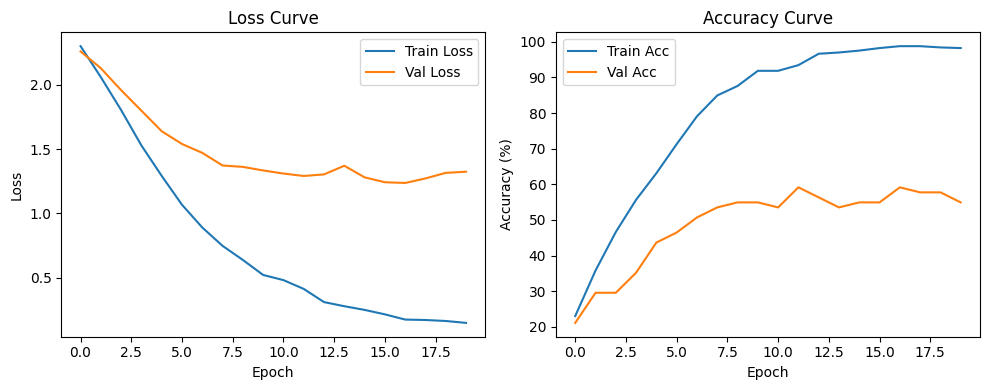

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import os

# Define your model before using it here
# from your_model_file import VGG19_LSTM

# Setup
num_classes = 11
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DenseNet121_LSTM(num_classes=num_classes).to(device)

# Loss, optimizer, scheduler
class_weights = torch.tensor([1.0] * num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Mixed Precision
scaler = torch.cuda.amp.GradScaler()

# Early stopping
patience = 3
best_val_loss = float('inf')
early_stop_counter = 0

# Tracking
history = {
    'train_loss': [],
    'val_loss': [],
    'train_accuracy': [],
    'val_accuracy': []
}

# Dataloaders (You must define `train_loader` and `valid_loader` before this)
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()

        torch.cuda.empty_cache()

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * train_correct / train_total
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, targets in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]"):
            inputs = inputs.to(device)
            targets = targets.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

            torch.cuda.empty_cache()

    val_loss /= len(valid_loader.dataset)
    val_accuracy = 100. * val_correct / val_total
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "densenet_model.pth")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

# Save training history as a .pt file
torch.save(history, "training_history_densenet.pt")

# Optionally, save as CSV
df_history = pd.DataFrame(history)
df_history.to_csv("training_history_densenet.csv", index=False)

# Plotting results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_accuracy'], label='Train Acc')
plt.plot(history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.savefig("training_plot.png")
plt.show()


Generating Confusion Matrix:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_35/636674623.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Generating Confusion Matrix: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


<Figure size 1000x800 with 0 Axes>

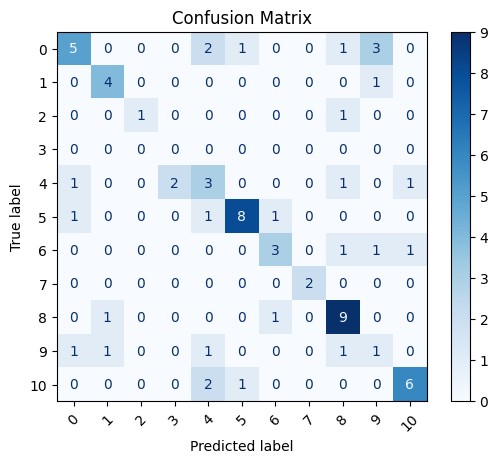

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Load best model
model.load_state_dict(torch.load("/kaggle/working/densenet_model.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(valid_loader, desc="Generating Confusion Matrix"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(num_classes)])

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


Resnet

In [25]:
import torch
import torch.nn as nn
import timm  # make sure you have 'timm' installed

# ResNetV2 + LSTM model definition
class ResNet50v2_LSTM(nn.Module):
    def __init__(self, num_classes, hidden_dim=256, num_layers=1):
        super(ResNet50v2_LSTM, self).__init__()

        # Load pretrained ResNetV2 from timm
        resnetv2 = timm.create_model('resnetv2_50x1_bit', pretrained=True)
        # Exclude avgpool and fc layers:
        self.backbone = nn.Sequential(*list(resnetv2.children())[:-2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Pool to (1, 1)

        self.feature_dim = 2048  # Output channels from ResNetV2

        # LSTM for temporal modeling
        self.lstm = nn.LSTM(input_size=self.feature_dim, hidden_size=hidden_dim,
                            num_layers=num_layers, batch_first=True)

        # Final classification layer
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x: [B, T, C, H, W]
        if x.shape[-1] == 3:
            x = x.permute(0, 1, 4, 2, 3)  # NHWC → NCHW if needed

        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)

        with torch.no_grad():
            x = self.backbone(x)        # [B*T, 2048, H', W']
            x = self.avgpool(x)         # [B*T, 2048, 1, 1]

        x = x.view(B, T, -1)            # [B, T, 2048]
        lstm_out, _ = self.lstm(x)      # [B, T, hidden_dim]
        out = self.classifier(lstm_out[:, -1, :])  # [B, num_classes]
        return out


# Usage example
if __name__ == "__main__":
    num_classes = 11
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = ResNet50v2_LSTM(num_classes).to(device)

    # Dummy input and target
    x = torch.randn((16, 16, 3, 224, 224)).to(device)  # [Batch, Time, C, H, W]
    y = torch.randint(0, num_classes, (16,)).to(device)

    # Training setup
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    scaler = torch.cuda.amp.GradScaler()

    # Forward pass with mixed precision
    with torch.amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
        output = model(x)
        print("Output shape:", output.shape)
        loss = criterion(output, y)
        print("Loss:", loss.item())

    # Backpropagation
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

/tmp/ipykernel_35/630890567.py:57: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Output shape: torch.Size([16, 11])
Loss: 2.4610595703125


/tmp/ipykernel_35/3640590230.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]/tmp/ipykernel_35/3640590230.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 [Valid]:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_35/3640590230.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 1 | Train Loss: 2.3766 | Train Acc: 11.52% | Val Loss: 2.3427 | Val Acc: 19.72%


Epoch 2/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 2 | Train Loss: 2.2529 | Train Acc: 25.53% | Val Loss: 2.3238 | Val Acc: 18.31%


Epoch 3/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 3 | Train Loss: 2.1851 | Train Acc: 29.08% | Val Loss: 2.2768 | Val Acc: 23.94%


Epoch 4/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 4 | Train Loss: 2.1596 | Train Acc: 29.26% | Val Loss: 2.2572 | Val Acc: 21.13%


Epoch 5/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 5 | Train Loss: 2.1421 | Train Acc: 28.72% | Val Loss: 2.2362 | Val Acc: 23.94%


Epoch 6/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 6 | Train Loss: 2.1081 | Train Acc: 32.09% | Val Loss: 2.2181 | Val Acc: 21.13%


Epoch 7/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 7 | Train Loss: 2.0747 | Train Acc: 31.38% | Val Loss: 2.1908 | Val Acc: 19.72%


Epoch 8/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 8 | Train Loss: 2.0612 | Train Acc: 29.26% | Val Loss: 2.2030 | Val Acc: 22.54%


Epoch 9/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 9 | Train Loss: 2.0611 | Train Acc: 32.09% | Val Loss: 2.1803 | Val Acc: 26.76%


Epoch 10/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 10 | Train Loss: 2.0244 | Train Acc: 35.46% | Val Loss: 2.1465 | Val Acc: 25.35%


Epoch 11/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 11 | Train Loss: 2.0020 | Train Acc: 33.69% | Val Loss: 2.1366 | Val Acc: 26.76%


Epoch 12/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 12 | Train Loss: 1.9967 | Train Acc: 38.30% | Val Loss: 2.1438 | Val Acc: 26.76%


Epoch 13/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 13 | Train Loss: 1.9608 | Train Acc: 39.01% | Val Loss: 2.1065 | Val Acc: 26.76%


Epoch 14/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 14 | Train Loss: 1.9343 | Train Acc: 38.48% | Val Loss: 2.0587 | Val Acc: 28.17%


Epoch 15/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 15 | Train Loss: 1.9110 | Train Acc: 40.78% | Val Loss: 2.0538 | Val Acc: 29.58%


Epoch 16/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 16 | Train Loss: 1.8901 | Train Acc: 41.84% | Val Loss: 2.0265 | Val Acc: 32.39%


Epoch 17/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 17 | Train Loss: 1.8697 | Train Acc: 44.50% | Val Loss: 2.0074 | Val Acc: 33.80%


Epoch 18/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 18 | Train Loss: 1.8372 | Train Acc: 43.79% | Val Loss: 1.9645 | Val Acc: 32.39%


Epoch 19/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 19 | Train Loss: 1.8124 | Train Acc: 45.74% | Val Loss: 1.9602 | Val Acc: 32.39%


Epoch 20/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 20 | Train Loss: 1.7983 | Train Acc: 46.28% | Val Loss: 1.9631 | Val Acc: 30.99%


Epoch 21/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 21 | Train Loss: 1.7685 | Train Acc: 49.29% | Val Loss: 1.9384 | Val Acc: 33.80%


Epoch 22/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 22 | Train Loss: 1.7473 | Train Acc: 49.11% | Val Loss: 1.9036 | Val Acc: 32.39%


Epoch 23/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 23 | Train Loss: 1.7193 | Train Acc: 51.24% | Val Loss: 1.8878 | Val Acc: 35.21%


Epoch 24/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 24 | Train Loss: 1.7301 | Train Acc: 50.35% | Val Loss: 1.9038 | Val Acc: 42.25%


Epoch 25/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 25 | Train Loss: 1.7406 | Train Acc: 49.11% | Val Loss: 1.8794 | Val Acc: 39.44%


Epoch 26/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 26 | Train Loss: 1.7182 | Train Acc: 49.11% | Val Loss: 1.9085 | Val Acc: 36.62%


Epoch 27/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 27 | Train Loss: 1.7230 | Train Acc: 52.30% | Val Loss: 1.8876 | Val Acc: 39.44%


Epoch 28/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 28 | Train Loss: 1.6833 | Train Acc: 51.77% | Val Loss: 1.8573 | Val Acc: 36.62%


Epoch 29/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 29 | Train Loss: 1.6738 | Train Acc: 52.66% | Val Loss: 1.8150 | Val Acc: 39.44%


Epoch 30/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 30 | Train Loss: 1.6464 | Train Acc: 52.84% | Val Loss: 1.8170 | Val Acc: 39.44%


Epoch 31/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 31 | Train Loss: 1.6193 | Train Acc: 54.26% | Val Loss: 1.8391 | Val Acc: 33.80%


Epoch 32/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 32 | Train Loss: 1.6168 | Train Acc: 51.42% | Val Loss: 1.7744 | Val Acc: 40.85%


Epoch 33/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 33 | Train Loss: 1.6005 | Train Acc: 54.61% | Val Loss: 1.7863 | Val Acc: 42.25%


Epoch 34/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 34 | Train Loss: 1.5958 | Train Acc: 54.96% | Val Loss: 1.8233 | Val Acc: 42.25%


Epoch 35/50 [Valid]: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 35 | Train Loss: 1.5827 | Train Acc: 53.90% | Val Loss: 1.7884 | Val Acc: 39.44%
Early stopping triggered.


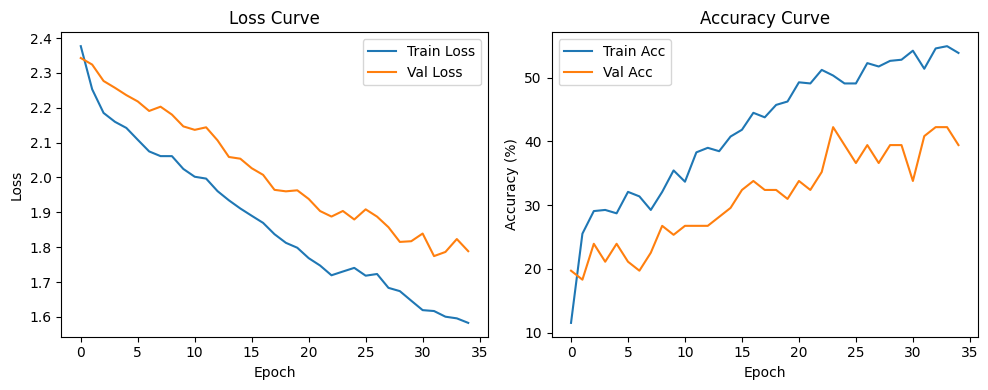

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import os

# Define your model before using it here
# from your_model_file import VGG19_LSTM

# Setup
num_classes = 11
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet50v2_LSTM(num_classes=num_classes).to(device)

# Loss, optimizer, scheduler
class_weights = torch.tensor([1.0] * num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Mixed Precision
scaler = torch.cuda.amp.GradScaler()

# Early stopping
patience = 3
best_val_loss = float('inf')
early_stop_counter = 0

# Tracking
history = {
    'train_loss': [],
    'val_loss': [],
    'train_accuracy': [],
    'val_accuracy': []
}

# Dataloaders (You must define `train_loader` and `valid_loader` before this)
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()

        torch.cuda.empty_cache()

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * train_correct / train_total
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, targets in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]"):
            inputs = inputs.to(device)
            targets = targets.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

            torch.cuda.empty_cache()

    val_loss /= len(valid_loader.dataset)
    val_accuracy = 100. * val_correct / val_total
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "resnet50v2_model.pth")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

# Save training history as a .pt file
torch.save(history, "training_history_resnet50v2.pt")

# Optionally, save as CSV
df_history = pd.DataFrame(history)
df_history.to_csv("training_history_resnet50v2.csv", index=False)

# Plotting results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_accuracy'], label='Train Acc')
plt.plot(history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.savefig("training_plot.png")
plt.show()


Generating Confusion Matrix:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_35/349381481.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Generating Confusion Matrix: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of labels (11).

<Figure size 1000x800 with 0 Axes>

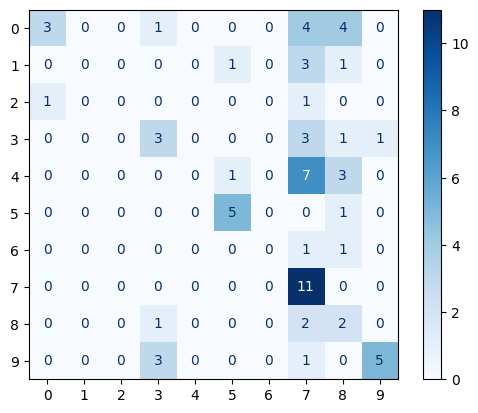

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Load best model
model.load_state_dict(torch.load("/kaggle/working/resnet50v2_model.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(valid_loader, desc="Generating Confusion Matrix"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(num_classes)])

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


**Experiments Below**

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler

# --- Optimized Diffusion Model Components ---
class DiffusionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, out_channels),
            nn.SiLU()
        )
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.SiLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.SiLU()
        )
        
        self.residual = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        
    def forward(self, x, t):
        h = self.conv1(x)
        t_emb = self.time_mlp(t)
        h = h + t_emb[:, :, None, None]
        h = self.conv2(h)
        return h + self.residual(x)

class DiffusionEncoder(nn.Module):
    def __init__(self, input_channels=3, base_dim=32, time_emb_dim=64):  # Reduced dimensions
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )
        
        self.down1 = DiffusionBlock(input_channels, base_dim, time_emb_dim)
        self.down2 = DiffusionBlock(base_dim, base_dim*2, time_emb_dim)
        self.down3 = DiffusionBlock(base_dim*2, base_dim*4, time_emb_dim)
        self.down4 = DiffusionBlock(base_dim*4, base_dim*8, time_emb_dim)
        
        self.pool = nn.AvgPool2d(2)
        
    def forward(self, x, t):
        t_emb = self.time_mlp(t)
        
        # Downsample path with gradient checkpointing
        x1 = torch.utils.checkpoint.checkpoint(self.down1, x, t_emb)
        x2 = torch.utils.checkpoint.checkpoint(self.down2, self.pool(x1), t_emb)
        x3 = torch.utils.checkpoint.checkpoint(self.down3, self.pool(x2), t_emb)
        x4 = torch.utils.checkpoint.checkpoint(self.down4, self.pool(x3), t_emb)
        
        # Global average pooling
        x = F.adaptive_avg_pool2d(x4, (1, 1))
        return x.view(x.size(0), -1)

# --- Physics-Informed Classifier ---
class PINNClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # Reduced size
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)  # Reduced size
        self.bn2 = nn.BatchNorm1d(64)
        self.output = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.3)
        self.act = nn.GELU()
        
    def forward(self, x):
        x = self.dropout(self.act(self.bn1(self.fc1(x))))
        x = self.dropout(self.act(self.bn2(self.fc2(x))))
        return self.output(x)
    
    def physics_loss(self, feats):
        if not feats.requires_grad:
            return torch.tensor(0.0, device=feats.device)
        
        # Calculate second derivative with gradient checkpointing
        with torch.enable_grad():
            grad1 = torch.autograd.grad(feats.sum(), feats, create_graph=True)[0]
            grad2 = torch.autograd.grad(grad1.sum(), feats, retain_graph=True)[0]
        return grad2.pow(2).mean()

# --- Combined Model ---
class DiffusionPINN(nn.Module):
    def __init__(self, num_classes, input_channels=3, time_emb_dim=64):
        super().__init__()
        self.encoder = DiffusionEncoder(input_channels, time_emb_dim=time_emb_dim)
        self.classifier = PINNClassifier(256, num_classes)  # base_dim*8 = 256
        
    def forward(self, x, t, require_grad=False):
        # Process frames in chunks to save memory
        B, T, H, W, C = x.shape
        chunk_size = 4  # Process 4 frames at a time
        num_chunks = T // chunk_size
        
        # Process each chunk separately
        feats_chunks = []
        for i in range(num_chunks):
            chunk = x[:, i*chunk_size:(i+1)*chunk_size, :, :, :]
            chunk = chunk.reshape(B * chunk_size, H, W, C).permute(0, 3, 1, 2)
            t_chunk = t.view(B, T, 1)[:, i*chunk_size:(i+1)*chunk_size, :].reshape(B * chunk_size, 1)
            
            with autocast():
                feats = self.encoder(chunk, t_chunk)
            feats_chunks.append(feats.view(B, chunk_size, -1))
        
        # Combine features from all chunks
        feats = torch.cat(feats_chunks, dim=1).mean(dim=1)  # (B, 256)
        
        if require_grad:
            feats = feats.requires_grad_()
            
        logits = self.classifier(feats)
        return logits, feats
    
    def total_loss(self, output, target, features, lambda_phys=0.01):
        ce_loss = F.cross_entropy(output, target)
        phys_loss = self.classifier.physics_loss(features)
        return ce_loss + lambda_phys * phys_loss

# --- Training Setup ---
def get_timesteps(batch_size, seq_len, device):
    """Generate random timesteps for diffusion process"""
    return torch.rand(batch_size * seq_len, 1, device=device)

# Initialize model
num_classes = 11
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DiffusionPINN(num_classes).to(device)

# Optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = GradScaler()

# Create DataLoaders with original batch sizes
train_loader = DataLoader(train_dataset, batch_size=564, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=71, shuffle=False, pin_memory=True)

# --- Training Loop ---
best_val_loss = float('inf')
early_stop_counter = 0
train_metrics, val_metrics = [], []

for epoch in range(50):
    # Training
    model.train()
    train_loss, correct, total = 0, 0, 0
    
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        t = get_timesteps(x.size(0), x.size(1), device)
        
        optimizer.zero_grad()
        
        with autocast():
            out, feats = model(x, t, require_grad=True)
            loss = model.total_loss(out, y, feats)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item() * x.size(0)
        _, pred = out.max(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_acc = 100. * correct / total
    
    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    all_preds, all_targets = [], []
    
    with torch.no_grad():
        for x, y in tqdm(valid_loader, desc=f"Epoch {epoch+1} [Valid]"):
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            t = get_timesteps(x.size(0), x.size(1), device)
            
            with autocast():
                out, _ = model(x, t)
                loss = F.cross_entropy(out, y)
            
            val_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            val_correct += (pred == y).sum().item()
            val_total += y.size(0)
            
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(y.cpu().numpy())
    
    val_loss /= len(valid_loader.dataset)
    val_acc = 100. * val_correct / val_total
    
    # Save metrics
    train_metrics.append((train_loss, train_acc))
    val_metrics.append((val_loss, val_acc))
    
    print(f"\nEpoch {epoch+1}")
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.2f}%")
    
    # Early stopping and model saving
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        
        # Evaluation metrics
        print("\nClassification Report:")
        print(classification_report(all_targets, all_preds, target_names=[str(i) for i in range(num_classes)]))
        
        # Confusion matrix
        cm = confusion_matrix(all_targets, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()
    else:
        early_stop_counter += 1
        if early_stop_counter >= 3:
            print("\nEarly stopping triggered")
            break

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot([x[0] for x in train_metrics], label='Train')
plt.plot([x[0] for x in val_metrics], label='Val')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([x[1] for x in train_metrics], label='Train')
plt.plot([x[1] for x in val_metrics], label='Val')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_35/3996454943.py:148: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_35/3996454943.py:170: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_35/3996454943.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details o

OutOfMemoryError: CUDA out of memory. Tried to allocate 6.75 GiB. GPU 0 has a total capacity of 15.89 GiB of which 2.45 GiB is free. Process 2505 has 13.42 GiB memory in use. Of the allocated memory 13.09 GiB is allocated by PyTorch, and 10.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Of course! The "equation" for the PINN classifier in your code can be broken down into two main parts:

The Forward Pass Equation: This describes the architecture of the neural network itself—how an input is transformed into an output.

The Loss Function Equation: This is what makes it a "PINN". It combines the standard classification loss with a "physics-informed" term that acts as a regularizer.

Let's break down each part.

1. The Classifier's Forward Pass Equation

Your PINNClassifier is a standard Multi-Layer Perceptron (MLP) with two hidden layers and a tanh activation function.

Let's define the mathematical notation:

z: The input feature vector to the classifier (output from the DiffusionEncoder). dim(z) = 512.

W₁, b₁: Weight matrix and bias vector for the first hidden layer (fc1).

W₂, b₂: Weight matrix and bias vector for the second hidden layer (fc2).

W₃, b₃: Weight matrix and bias vector for the output layer (output).

y_logits: The final output of the network (the raw scores for each class before softmax). dim(y_logits) = 11.

tanh: The hyperbolic tangent activation function.

The forward pass y_logits = classifier(z) can be written as a sequence of operations:

First Hidden Layer:

Equation: h₁ = tanh(W₁z + b₁)

Explanation: A linear transformation of the input z followed by the tanh activation.

Second Hidden Layer:

Equation: h₂ = tanh(W₂h₁ + b₂)

Explanation: A linear transformation of the first hidden layer's output h₁ followed by the tanh activation.

Output Layer:

Equation: y_logits = W₃h₂ + b₃

Explanation: A final linear transformation of the second hidden layer's output h₂ to produce the class logits.

Combining these into a single equation, the function f(z) computed by your PINNClassifier is:

y_logits = f(z) = W₃(tanh(W₂(tanh(W₁z + b₁)) + b₂)) + b₃

2. The Total Loss Function Equation

This is where the "Physics-Informed" aspect comes into play. The total loss is a weighted sum of the classification loss and a physics-based regularization term.

Let's define the additional notation:

L_total: The total loss that is minimized during training.

L_class: The classification loss (in your code, this is the LabelSmoothingLoss).

L_phys: The "physics-informed" loss, which penalizes some property of the network's behavior.

λ_phys: A hyperparameter that balances the importance of the two loss terms (you set lambda_phys=0.01).

The Total Loss Equation:

L_total = L_class(y_logits, y_true) + λ_phys * L_phys

Now, let's look at the L_phys term specifically.

The "Physics-Informed" Loss (L_phys)

Your physics_loss function is defined as:

Generated python
def physics_loss(self, feats):
    grad = torch.autograd.grad(feats.sum(), feats, create_graph=True)[0]
    loss = (grad ** 2).mean()
    return loss


Here, feats is the input to the classifier, which we've called z.

Let's translate this into an equation:

L_phys = mean( ( ∇_z ( Σ zᵢ ) )² )

Where:

z is the feature vector input to the classifier.

Σ zᵢ is the sum of all elements in the feature vector z.

∇_z is the gradient with respect to z.

Important Caveat on the Physics Loss Implementation:

In your current implementation, the gradient ∇_z ( Σ zᵢ ) will always be a vector of ones. Therefore, (∇_z ( Σ zᵢ ))² will also be a vector of ones, and its mean will be 1. This means L_phys is a constant value and does not effectively regularize the network based on its parameters.

A more conventional PINN approach would be to compute the gradient of the network's output with respect to its input. For example, if your "physical law" was that the output should not change rapidly with respect to the input, you would calculate the gradient of y_logits with respect to z.

If we were to correct the implementation to reflect a more typical PINN regularization (e.g., minimizing the gradient of the output w.r.t the input), the equation would look like this:

L_phys_typical = mean( ( ∇_z ( Σ f(z)ᵢ ) )² )

Where f(z) is the output of the classifier. This loss term would penalize models where the output is highly sensitive to small changes in the input features z, encouraging a "smoother" function.

Summary

In short, your model is described by:

Architecture Equation:
y_logits = W₃(tanh(W₂(tanh(W₁z + b₁)) + b₂)) + b₃

Loss Function Equation:
L_total = L_class(y_logits, y_true) + λ_phys * L_phys
where L_phys is calculated based on the gradient of the classifier's input with respect to itself.

/tmp/ipykernel_35/2095119325.py:89: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
Epoch 1/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]/tmp/ipykernel_35/2095119325.py:110: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 [Valid]:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_35/2095119325.py:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 [Valid]: 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 1 | Train Loss: 1.5403 | Train Acc: 37.06% | Val Loss: 1.3854 | Val Acc: 38.03%


Epoch 2/50 [Valid]: 100%|██████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 2 | Train Loss: 1.1282 | Train Acc: 63.30% | Val Loss: 1.1744 | Val Acc: 49.30%


Epoch 3/50 [Valid]: 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 3 | Train Loss: 0.8782 | Train Acc: 77.48% | Val Loss: 1.1123 | Val Acc: 56.34%


Epoch 4/50 [Valid]: 100%|██████████| 5/5 [00:01<00:00,  3.57it/s]


Epoch 4 | Train Loss: 0.6697 | Train Acc: 86.70% | Val Loss: 0.8771 | Val Acc: 69.01%


Epoch 5/50 [Valid]: 100%|██████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 5 | Train Loss: 0.4983 | Train Acc: 93.79% | Val Loss: 0.8856 | Val Acc: 63.38%


Epoch 6/50 [Valid]: 100%|██████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 6 | Train Loss: 0.3560 | Train Acc: 98.58% | Val Loss: 0.8261 | Val Acc: 69.01%


Epoch 7/50 [Valid]: 100%|██████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 7 | Train Loss: 0.2990 | Train Acc: 97.52% | Val Loss: 0.9306 | Val Acc: 63.38%


Epoch 8/50 [Valid]: 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 8 | Train Loss: 0.2134 | Train Acc: 99.11% | Val Loss: 0.6977 | Val Acc: 76.06%


Epoch 9/50 [Valid]: 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]


Epoch 9 | Train Loss: 0.1573 | Train Acc: 99.29% | Val Loss: 0.6397 | Val Acc: 80.28%


Epoch 10/50 [Valid]: 100%|██████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 10 | Train Loss: 0.1326 | Train Acc: 99.47% | Val Loss: 0.7686 | Val Acc: 70.42%


Epoch 11/50 [Valid]: 100%|██████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 11 | Train Loss: 0.1080 | Train Acc: 99.82% | Val Loss: 0.7497 | Val Acc: 66.20%


Epoch 12/50 [Valid]: 100%|██████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 12 | Train Loss: 0.0783 | Train Acc: 100.00% | Val Loss: 0.6507 | Val Acc: 70.42%
Early stopping triggered.


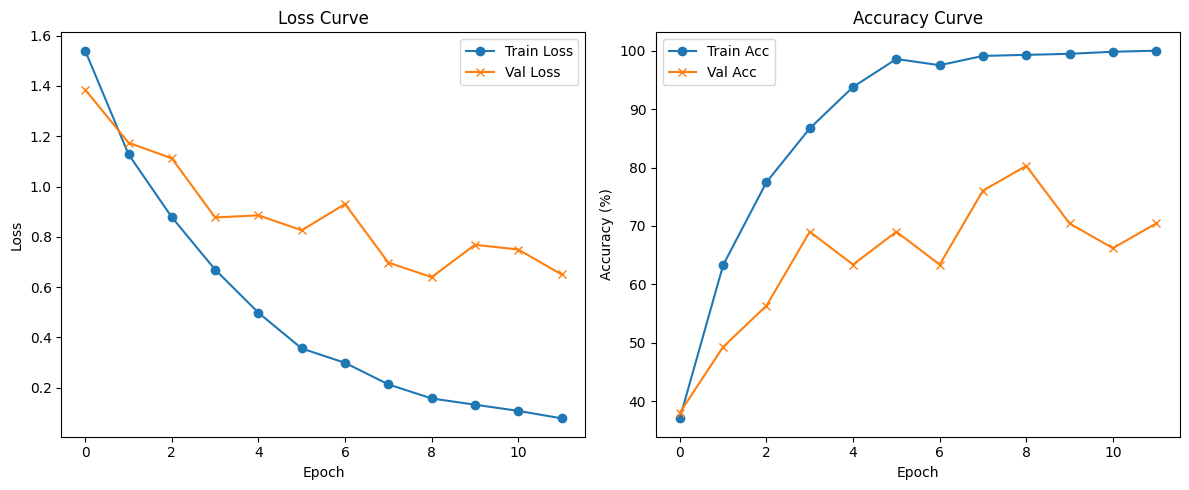

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchvision.models import resnet18

# --- Label Smoothing ---
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.kl_div = nn.KLDivLoss(reduction='batchmean')

    def forward(self, pred, target):
        pred = torch.log_softmax(pred, dim=-1)
        true_dist = torch.zeros_like(pred)
        true_dist.fill_(self.smoothing / (self.cls - 1))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return self.kl_div(pred, true_dist)

# --- Diffusion Encoder (ResNet as placeholder) ---
class DiffusionEncoder(nn.Module):
    def __init__(self):
        super(DiffusionEncoder, self).__init__()
        base_model = resnet18(pretrained=True)
        self.encoder = nn.Sequential(*list(base_model.children())[:-1])  # remove classifier
        self.output_dim = base_model.fc.in_features

    def forward(self, x):
        return self.encoder(x).view(x.size(0), -1)

# --- Physics-Informed PINN Classifier ---
class PINNClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(PINNClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.act = nn.Tanh()
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        return self.output(x)

    def physics_loss(self, feats):
        if not feats.requires_grad:
            return torch.tensor(0.0, device=feats.device)
        grad = torch.autograd.grad(feats.sum(), feats, create_graph=True)[0]
        loss = (grad ** 2).mean()
        return loss

# --- Final Model ---
class DiffusionPINNModel(nn.Module):
    def __init__(self, num_classes):
        super(DiffusionPINNModel, self).__init__()
        self.encoder = DiffusionEncoder()
        self.classifier = PINNClassifier(self.encoder.output_dim, num_classes)

    def forward(self, x, require_grad=False):
        B, T, H, W, C = x.shape
        x = x.view(B * T, H, W, C).permute(0, 3, 1, 2)  # (B*T, C, H, W)
        feats = self.encoder(x)  # (B*T, feat_dim)
        feats = feats.view(B, T, -1).mean(dim=1)
        if require_grad:
            feats = feats.requires_grad_()
        logits = self.classifier(feats)
        return logits, feats

    def total_loss(self, output, target, features, criterion, lambda_phys=0.01):
        ce_loss = criterion(output, target)
        phys_loss = self.classifier.physics_loss(features)
        return ce_loss + lambda_phys * phys_loss

# --- Setup ---
num_classes = 11
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DiffusionPINNModel(num_classes).to(device)
criterion = LabelSmoothingLoss(classes=num_classes, smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Use GradScaler only if CUDA is available
scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

# --- Early Stopping ---
patience = 3
best_val_loss = float('inf')
early_stop_counter = 0
train_accuracies, val_accuracies, train_losses, val_losses = [], [], [], []

# --- Training Loop ---
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        if scaler is not None:
            with torch.cuda.amp.autocast():
                out, feats = model(x, require_grad=True)
                loss = model.total_loss(out, y, feats, criterion)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            out, feats = model(x, require_grad=True)
            loss = model.total_loss(out, y, feats, criterion)
            loss.backward()
            optimizer.step()

        running_train_loss += loss.item() * x.size(0)
        _, pred = out.max(1)
        total_train += y.size(0)
        correct_train += (pred == y).sum().item()

    avg_train_loss = running_train_loss / len(train_loader.dataset)
    train_accuracy = 100. * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # --- Validation ---
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for x, y in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]"):
            x, y = x.to(device), y.to(device)
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    out, _ = model(x, require_grad=False)
                    loss = criterion(out, y)  # Only classification loss for validation
            else:
                out, _ = model(x, require_grad=False)
                loss = criterion(out, y)

            running_val_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            total_val += y.size(0)
            correct_val += (pred == y).sum().item()

    avg_val_loss = running_val_loss / len(valid_loader.dataset)
    val_accuracy = 100. * correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

# --- Plotting ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='x')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc', marker='o')
plt.plot(val_accuracies, label='Val Acc', marker='x')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

Processing Training set: 100%|██████████| 36/36 [00:04<00:00,  7.87it/s]



Training Set Class Distribution:
----------------------------------------
 Class  Count  Percentage
     0     49        8.69
     1     28        4.96
     2     23        4.08
     3     44        7.80
     4     70       12.41
     5     42        7.45
     6     57       10.11
     7     33        5.85
     8    125       22.16
     9     49        8.69
    10     44        7.80
----------------------------------------
Total samples: 564
Classes: 11


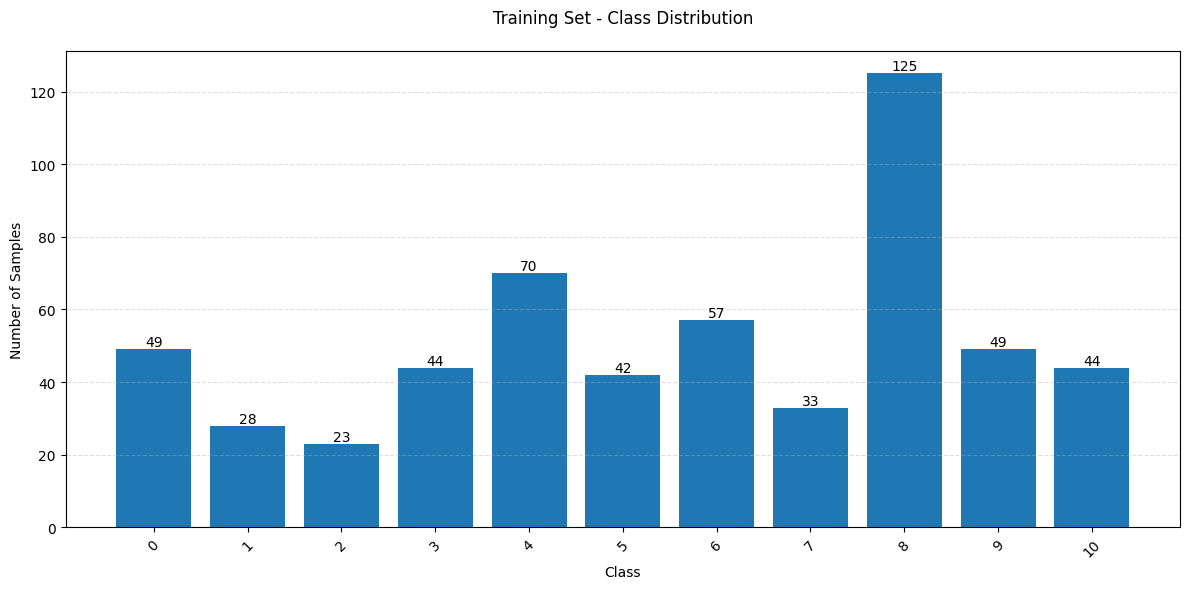

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

def show_class_counts(loader, dataset_name="Training"):
    # Collect all labels
    all_labels = []
    for _, labels in tqdm(loader, desc=f"Processing {dataset_name} set"):
        all_labels.extend(labels.numpy())
    
    # Count class occurrences
    class_counts = Counter(all_labels)
    sorted_counts = sorted(class_counts.items())
    
    # Create DataFrame for nice display
    df = pd.DataFrame(sorted_counts, columns=['Class', 'Count'])
    df['Percentage'] = (df['Count'] / df['Count'].sum() * 100).round(2)
    
    # Display table
    print(f"\n{dataset_name} Set Class Distribution:")
    print("-" * 40)
    print(df.to_string(index=False))
    print("-" * 40)
    print(f"Total samples: {df['Count'].sum()}")
    print(f"Classes: {len(df)}")
    
    # Plot distribution
    plt.figure(figsize=(12, 6))
    bars = plt.bar(df['Class'].astype(str), df['Count'])
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,}',
                ha='center', va='bottom')
    
    plt.title(f'{dataset_name} Set - Class Distribution', pad=20)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()
    
    return df

# Show training set counts
train_counts = show_class_counts(train_loader, "Training")

# If you want to check validation set as well:
# valid_counts = show_class_counts(valid_loader, "Validation")

Testing:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_35/341863281.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Testing: 100%|██████████| 5/5 [00:01<00:00,  3.86it/s]



Test Results:
Loss: 0.6397 | Accuracy: 80.28%


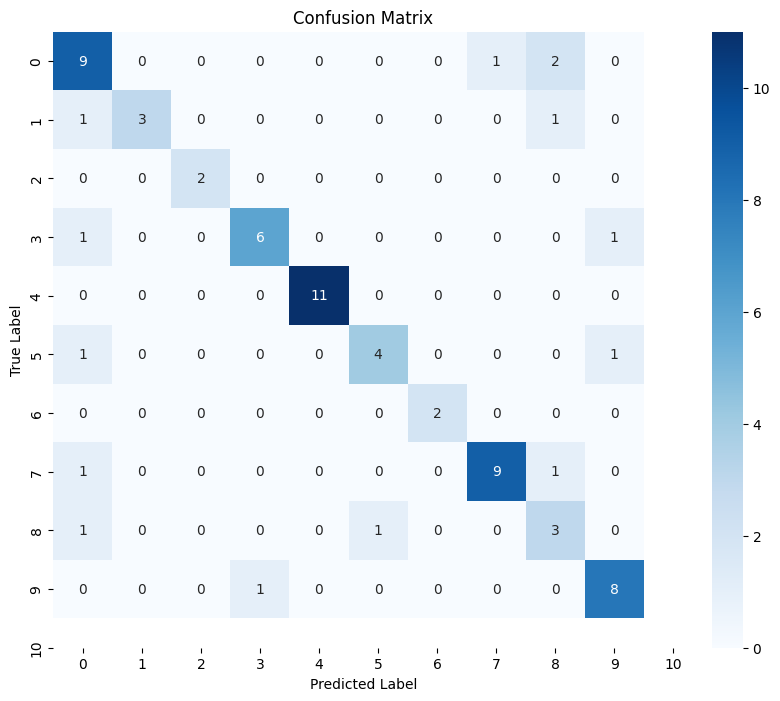


Class-wise Accuracy:
Class 0: 75.00% (9/12)
Class 1: 60.00% (3/5)
Class 2: 100.00% (2/2)
Class 3: No samples
Class 4: 75.00% (6/8)
Class 5: 100.00% (11/11)
Class 6: 66.67% (4/6)
Class 7: 100.00% (2/2)
Class 8: 81.82% (9/11)
Class 9: 60.00% (3/5)
Class 10: 88.89% (8/9)

Classification Report:


ValueError: Number of classes, 10, does not match size of target_names, 11. Try specifying the labels parameter

In [26]:
# Load the best saved model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# --- Test Evaluation ---
test_loss = 0.0
correct = 0
total = 0
all_preds = []
all_targets = []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x, y = x.to(device), y.to(device)
        
        # Forward pass
        if scaler is not None:
            with torch.cuda.amp.autocast():
                out, _ = model(x, require_grad=False)
                loss = criterion(out, y)
        else:
            out, _ = model(x, require_grad=False)
            loss = criterion(out, y)
        
        # Calculate metrics
        test_loss += loss.item() * x.size(0)
        _, pred = torch.max(out, 1)
        correct += (pred == y).sum().item()
        total += y.size(0)
        
        # Store predictions and targets for confusion matrix
        all_preds.extend(pred.cpu().numpy())
        all_targets.extend(y.cpu().numpy())

# Calculate final metrics
test_loss = test_loss / len(test_loader.dataset)
test_accuracy = 100. * correct / total

print(f"\nTest Results:")
print(f"Loss: {test_loss:.4f} | Accuracy: {test_accuracy:.2f}%")

# --- Confusion Matrix ---
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(num_classes), 
            yticklabels=range(num_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# --- Class-wise Accuracy ---
class_correct = [0 for _ in range(num_classes)]
class_total = [0 for _ in range(num_classes)]

for i in range(len(all_targets)):
    class_total[all_targets[i]] += 1
    if all_targets[i] == all_preds[i]:
        class_correct[all_targets[i]] += 1

print("\nClass-wise Accuracy:")
for i in range(num_classes):
    if class_total[i] > 0:
        print(f"Class {i}: {100 * class_correct[i] / class_total[i]:.2f}% ({class_correct[i]}/{class_total[i]})")
    else:
        print(f"Class {i}: No samples")

# --- Additional Metrics ---
from sklearn.metrics import classification_report

print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=[str(i) for i in range(num_classes)]))

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.checkpoint import checkpoint
import timm

torch.backends.cudnn.benchmark = True
torch.cuda.set_per_process_memory_fraction(0.9, device=0)

# --- Group Normalization ---
class GroupNormalization(nn.Module):
    def __init__(self, num_channels, num_groups=8, eps=1e-5):
        super(GroupNormalization, self).__init__()
        self.num_groups = min(num_groups, num_channels)
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(num_channels))
        self.offset = nn.Parameter(torch.zeros(num_channels))

    def forward(self, x):
        N, C = x.size(0), x.size(1)
        G = self.num_groups
        while C % G != 0 and G > 1:
            G -= 1

        if x.dim() == 2:
            x = x.view(N, G, C // G)
            mean = x.mean(dim=2, keepdim=True)
            var = x.var(dim=2, keepdim=True, unbiased=False)
            x = (x - mean) / torch.sqrt(var + self.eps)
            x = x.view(N, C)
        elif x.dim() == 4:
            H, W = x.size(2), x.size(3)
            x = x.view(N, G, C // G, H, W)
            mean = x.mean(dim=[2, 3, 4], keepdim=True)
            var = x.var(dim=[2, 3, 4], keepdim=True, unbiased=False)
            x = (x - mean) / torch.sqrt(var + self.eps)
            x = x.view(N, C, H, W)

        return x * self.scale.view(1, -1, *([1] * (x.dim() - 2))) + \
               self.offset.view(1, -1, *([1] * (x.dim() - 2)))

# --- Model Definition ---
class TwoBranchSwinDarkNetBiLSTM(nn.Module):
    def __init__(self, num_classes):
        super(TwoBranchSwinDarkNetBiLSTM, self).__init__()

        # Swin Transformer
        swin = models.swin_t(weights=models.Swin_T_Weights.DEFAULT)
        self.swin_features = nn.Sequential(*list(swin.children())[:-2])
        for param in self.swin_features.parameters():
            param.requires_grad = False
        for module in list(self.swin_features)[-2:]:
            for param in module.parameters():
                param.requires_grad = True

        # DarkNet
        darknet = timm.create_model("darknet53", pretrained=True, features_only=True)
        self.darknet_features = darknet
        for param in self.darknet_features.parameters():
            param.requires_grad = False
        last_block = list(self.darknet_features.children())[-1]
        for param in last_block.parameters():
            param.requires_grad = True

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.swin_out_features = 768
        self.darknet_out_features = self.darknet_features.feature_info[-1]['num_chs']

        self.gn_swin = GroupNormalization(self.swin_out_features, 8)
        self.gn_darknet = GroupNormalization(self.darknet_out_features, 8)
        self.dropout = nn.Dropout(0.5)

        self.lstm_input_size = self.swin_out_features + self.darknet_out_features
        self.lstm_hidden_size = 384
        self.lstm_layers = 3
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_size,
            hidden_size=self.lstm_hidden_size,
            num_layers=self.lstm_layers,
            batch_first=True,
            dropout=0.3,
            bidirectional=True
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            GroupNormalization(num_channels=self.lstm_hidden_size * 2, num_groups=8),
            nn.Linear(self.lstm_hidden_size * 2, 256),
            nn.ReLU(),
            GroupNormalization(256, 8),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            GroupNormalization(128, 8),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 1, 4, 2, 3)  # (B, T, C, H, W)
        B, T, C, H, W = x.shape
        all_features = []

        for t in range(T):
            x_t = x[:, t, :, :, :]

            swin_out = checkpoint(self.swin_features, x_t)
            swin_out = self.global_avg_pool(swin_out).squeeze(-1).squeeze(-1)
            swin_out = self.gn_swin(swin_out)

            darknet_feats = self.darknet_features(x_t)[-1]
            darknet_out = self.global_avg_pool(darknet_feats).squeeze(-1).squeeze(-1)
            darknet_out = self.gn_darknet(darknet_out)

            combined = torch.cat([swin_out, darknet_out], dim=1)
            combined = self.dropout(combined)
            all_features.append(combined)

        all_features = torch.stack(all_features, dim=1)
        lstm_out, _ = self.lstm(all_features)
        lstm_out = lstm_out[:, -1, :]
        output = self.fc(lstm_out)
        return output

# --- Training Setup ---
if __name__ == "__main__":
    num_classes = 11
    model = TwoBranchSwinDarkNetBiLSTM(num_classes)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    class_weights = torch.tensor([1.0] * num_classes).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-6)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=2, verbose=True)

    scaler = torch.cuda.amp.GradScaler()

    data_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Dummy input
    input_shape = (16, 16, 224, 224, 3)
    x = torch.randn(input_shape).to(device)
    y = torch.randint(0, num_classes, (input_shape[0],)).to(device)

    with torch.cuda.amp.autocast():
        output = model(x)
        print("Output shape:", output.shape)
        loss = criterion(output, y)
        print("Loss:", loss.item())

    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    scheduler.step(loss)

    torch.cuda.empty_cache()
    del x, y, output, loss


Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:00<00:00, 206MB/s] 


model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_35/550960793.py:139: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_35/550960793.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differ

Output shape: torch.Size([16, 11])
Loss: 2.650146484375


/tmp/ipykernel_35/874114214.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Correct initialization
Epoch 1/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]/tmp/ipykernel_35/874114214.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/util

Epoch 1 | Train Loss: 2.4816 | Train Acc: 15.96% | Val Loss: 2.2413 | Val Acc: 22.54%


Epoch 2/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


Epoch 2 | Train Loss: 2.1452 | Train Acc: 29.08% | Val Loss: 1.9652 | Val Acc: 30.99%


Epoch 3/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


Epoch 3 | Train Loss: 1.8455 | Train Acc: 40.60% | Val Loss: 1.6294 | Val Acc: 43.66%


Epoch 4/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


Epoch 4 | Train Loss: 1.6061 | Train Acc: 48.94% | Val Loss: 1.4950 | Val Acc: 49.30%


Epoch 5/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


Epoch 5 | Train Loss: 1.4069 | Train Acc: 57.62% | Val Loss: 1.4876 | Val Acc: 49.30%


Epoch 6/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


Epoch 6 | Train Loss: 1.2247 | Train Acc: 63.48% | Val Loss: 1.3610 | Val Acc: 53.52%


Epoch 7/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


Epoch 7 | Train Loss: 1.0725 | Train Acc: 67.91% | Val Loss: 1.3758 | Val Acc: 54.93%


Epoch 8/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]


Epoch 8 | Train Loss: 0.9203 | Train Acc: 73.58% | Val Loss: 1.2370 | Val Acc: 63.38%


Epoch 9/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


Epoch 9 | Train Loss: 0.7959 | Train Acc: 79.96% | Val Loss: 1.2096 | Val Acc: 61.97%


Epoch 10/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


Epoch 10 | Train Loss: 0.6752 | Train Acc: 84.57% | Val Loss: 1.1885 | Val Acc: 66.20%


Epoch 11/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


Epoch 11 | Train Loss: 0.5947 | Train Acc: 87.23% | Val Loss: 1.3068 | Val Acc: 64.79%


Epoch 12/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


Epoch 12 | Train Loss: 0.4697 | Train Acc: 91.49% | Val Loss: 1.1778 | Val Acc: 69.01%


Epoch 13/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


Epoch 13 | Train Loss: 0.4051 | Train Acc: 94.15% | Val Loss: 1.1854 | Val Acc: 66.20%


Epoch 14/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Epoch 14 | Train Loss: 0.3220 | Train Acc: 96.28% | Val Loss: 1.2399 | Val Acc: 66.20%


Epoch 15/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Epoch 15 | Train Loss: 0.2768 | Train Acc: 97.52% | Val Loss: 1.3561 | Val Acc: 67.61%
Early stopping triggered.


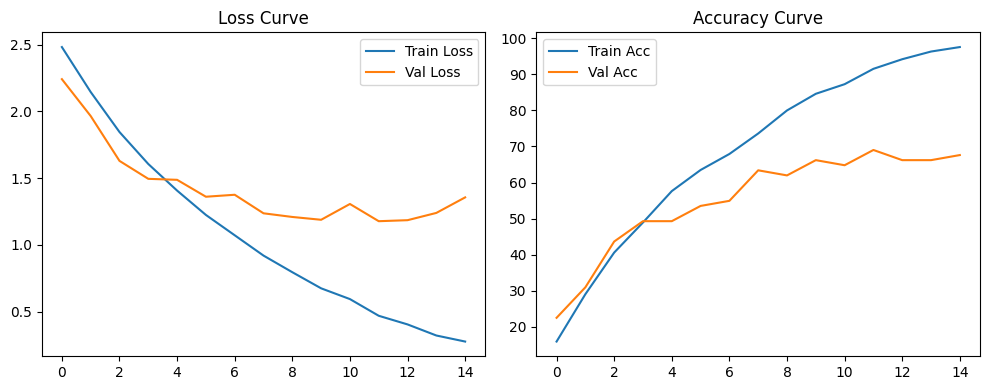

In [16]:
## Merge solve

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Setup
num_classes = 11
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TwoBranchSwinDarkNetBiLSTM(num_classes=num_classes).to(device)

# Loss, optimizer, scheduler
class_weights = torch.tensor([1.0] * num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Mixed Precision
scaler = torch.cuda.amp.GradScaler()  # Correct initialization

# Early stopping
patience = 3
best_val_loss = float('inf')
early_stop_counter = 0

# Tracking
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Dataloaders (You must define train_loader, valid_loader before this)
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        inputs = inputs.to(device)  # Regular tensor transfer
        targets = targets.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()

        torch.cuda.empty_cache()

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, targets in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]"):
            inputs = inputs.to(device)
            targets = targets.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

            torch.cuda.empty_cache()

    val_loss /= len(valid_loader.dataset)
    val_accuracy = 100. * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

# Plotting results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy Curve')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.checkpoint import checkpoint
import timm
import numpy as np

torch.backends.cudnn.benchmark = True
torch.cuda.set_per_process_memory_fraction(0.9, device=0)

# --- Group Normalization ---
class GroupNormalization(nn.Module):
    def __init__(self, num_channels, num_groups=8, eps=1e-5):
        super(GroupNormalization, self).__init__()
        self.num_groups = min(num_groups, num_channels)
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(num_channels))
        self.offset = nn.Parameter(torch.zeros(num_channels))

    def forward(self, x):
        N, C = x.size(0), x.size(1)
        G = self.num_groups
        while C % G != 0 and G > 1:
            G -= 1

        if x.dim() == 2:
            x = x.view(N, G, C // G)
            mean = x.mean(dim=2, keepdim=True)
            var = x.var(dim=2, keepdim=True, unbiased=False)
            x = (x - mean) / torch.sqrt(var + self.eps)
            x = x.view(N, C)
        elif x.dim() == 4:
            H, W = x.size(2), x.size(3)
            x = x.view(N, G, C // G, H, W)
            mean = x.mean(dim=[2, 3, 4], keepdim=True)
            var = x.var(dim=[2, 3, 4], keepdim=True, unbiased=False)
            x = (x - mean) / torch.sqrt(var + self.eps)
            x = x.view(N, C, H, W)

        return x * self.scale.view(1, -1, *([1] * (x.dim() - 2))) + \
               self.offset.view(1, -1, *([1] * (x.dim() - 2)))

# --- Label Smoothing Loss ---
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.kl_div = nn.KLDivLoss(reduction='batchmean')

    def forward(self, pred, target):
        pred = torch.log_softmax(pred, dim=-1)
        true_dist = torch.zeros_like(pred)
        true_dist.fill_(self.smoothing / (self.cls - 1))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return self.kl_div(pred, true_dist)

# --- Model Definition ---
class TwoBranchSwinDarkNetBiLSTM(nn.Module):
    def __init__(self, num_classes):
        super(TwoBranchSwinDarkNetBiLSTM, self).__init__()

        swin = models.swin_t(weights=models.Swin_T_Weights.DEFAULT)
        self.swin_features = nn.Sequential(*list(swin.children())[:-2])
        for param in self.swin_features.parameters():
            param.requires_grad = False
        for module in list(self.swin_features)[-2:]:
            for param in module.parameters():
                param.requires_grad = True

        darknet = timm.create_model("darknet53", pretrained=True, features_only=True)
        self.darknet_features = darknet
        for param in self.darknet_features.parameters():
            param.requires_grad = False
        last_block = list(self.darknet_features.children())[-1]
        for param in last_block.parameters():
            param.requires_grad = True

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.swin_out_features = 768
        self.darknet_out_features = self.darknet_features.feature_info[-1]['num_chs']

        self.gn_swin = GroupNormalization(self.swin_out_features, 8)
        self.gn_darknet = GroupNormalization(self.darknet_out_features, 8)
        self.dropout = nn.Dropout(0.6)

        self.lstm_input_size = self.swin_out_features + self.darknet_out_features
        self.lstm_hidden_size = 256
        self.lstm_layers = 2
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_size,
            hidden_size=self.lstm_hidden_size,
            num_layers=self.lstm_layers,
            batch_first=True,
            dropout=0.5,
            bidirectional=True
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            GroupNormalization(num_channels=self.lstm_hidden_size * 2, num_groups=8),
            nn.Linear(self.lstm_hidden_size * 2, 256),
            nn.ReLU(),
            GroupNormalization(256, 8),
            nn.Dropout(0.6),
            nn.Linear(256, 128),
            nn.ReLU(),
            GroupNormalization(128, 8),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 1, 4, 2, 3)  # (B, T, C, H, W)
        B, T, C, H, W = x.shape
        all_features = []

        for t in range(T):
            x_t = x[:, t, :, :, :]

            swin_out = checkpoint(self.swin_features, x_t)
            swin_out = self.global_avg_pool(swin_out).squeeze(-1).squeeze(-1)
            swin_out = self.gn_swin(swin_out)

            darknet_feats = self.darknet_features(x_t)[-1]
            darknet_out = self.global_avg_pool(darknet_feats).squeeze(-1).squeeze(-1)
            darknet_out = self.gn_darknet(darknet_out)

            combined = torch.cat([swin_out, darknet_out], dim=1)
            combined = self.dropout(combined)
            all_features.append(combined)

        all_features = torch.stack(all_features, dim=1)  # (B, T, F)
        lstm_out, _ = self.lstm(all_features)
        lstm_out = lstm_out[:, -1, :]
        output = self.fc(lstm_out)
        return output

# --- Training Setup (Model & Criterion) ---
if __name__ == "__main__":
    num_classes = 11
    model = TwoBranchSwinDarkNetBiLSTM(num_classes)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    criterion = LabelSmoothingLoss(classes=num_classes, smoothing=0.1)

    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=5e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=2, verbose=True)

    scaler = torch.cuda.amp.GradScaler()

    data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(0.3, 0.3, 0.3, 0.1),
        transforms.RandomGrayscale(p=0.1),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Dummy input for verification
    input_shape = (16, 16, 224, 224, 3)
    x = torch.randn(input_shape).to(device)
    y = torch.randint(0, num_classes, (input_shape[0],)).to(device)

    with torch.cuda.amp.autocast():
        output = model(x)
        print("Output shape:", output.shape)
        loss = criterion(output, y)
        print("Loss:", loss.item())

    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    scheduler.step(loss)

    torch.cuda.empty_cache()
    del x, y, output, loss


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_35/2539446170.py:153: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_35/2539446170.py:170: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Output shape: torch.Size([16, 11])
Loss: 1.9409185647964478


/tmp/ipykernel_35/954699550.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]/tmp/ipykernel_35/954699550.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 [Valid]:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_35/954699550.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


Epoch 1 | Train Loss: 2.0036 | Train Acc: 13.30% | Val Loss: 1.8195 | Val Acc: 16.90%


Epoch 2/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Epoch 2 | Train Loss: 1.9670 | Train Acc: 14.01% | Val Loss: 1.7944 | Val Acc: 22.54%


Epoch 3/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Epoch 3 | Train Loss: 1.8597 | Train Acc: 18.79% | Val Loss: 1.8049 | Val Acc: 21.13%


Epoch 4/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch 4 | Train Loss: 1.8158 | Train Acc: 21.28% | Val Loss: 1.7080 | Val Acc: 23.94%


Epoch 5/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]


Epoch 5 | Train Loss: 1.7356 | Train Acc: 25.00% | Val Loss: 1.6755 | Val Acc: 28.17%


Epoch 6/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch 6 | Train Loss: 1.6772 | Train Acc: 27.84% | Val Loss: 1.6026 | Val Acc: 30.99%


Epoch 7/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Epoch 7 | Train Loss: 1.6405 | Train Acc: 30.32% | Val Loss: 1.7385 | Val Acc: 26.76%


Epoch 8/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch 8 | Train Loss: 1.5722 | Train Acc: 32.62% | Val Loss: 1.5317 | Val Acc: 30.99%


Epoch 9/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Epoch 9 | Train Loss: 1.4933 | Train Acc: 36.52% | Val Loss: 1.5436 | Val Acc: 35.21%


Epoch 10/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch 10 | Train Loss: 1.4055 | Train Acc: 40.60% | Val Loss: 1.3668 | Val Acc: 47.89%


Epoch 11/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Epoch 11 | Train Loss: 1.3407 | Train Acc: 43.62% | Val Loss: 1.3857 | Val Acc: 45.07%


Epoch 12/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Epoch 12 | Train Loss: 1.2767 | Train Acc: 44.33% | Val Loss: 1.3471 | Val Acc: 45.07%


Epoch 13/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch 13 | Train Loss: 1.2289 | Train Acc: 47.34% | Val Loss: 1.4263 | Val Acc: 46.48%


Epoch 14/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch 14 | Train Loss: 1.1590 | Train Acc: 49.82% | Val Loss: 1.3305 | Val Acc: 46.48%


Epoch 15/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch 15 | Train Loss: 1.1654 | Train Acc: 49.82% | Val Loss: 1.2795 | Val Acc: 46.48%


Epoch 16/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch 16 | Train Loss: 1.0649 | Train Acc: 53.55% | Val Loss: 1.4235 | Val Acc: 42.25%


Epoch 17/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Epoch 17 | Train Loss: 1.0671 | Train Acc: 52.84% | Val Loss: 1.3050 | Val Acc: 46.48%


Epoch 18/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch 18 | Train Loss: 1.0152 | Train Acc: 57.45% | Val Loss: 1.2068 | Val Acc: 47.89%


Epoch 19/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch 19 | Train Loss: 0.9400 | Train Acc: 57.09% | Val Loss: 1.4705 | Val Acc: 42.25%


Epoch 20/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch 20 | Train Loss: 0.8988 | Train Acc: 62.23% | Val Loss: 1.2196 | Val Acc: 49.30%


Epoch 21/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch 21 | Train Loss: 0.8513 | Train Acc: 64.18% | Val Loss: 1.2029 | Val Acc: 52.11%


Epoch 22/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch 22 | Train Loss: 0.8159 | Train Acc: 64.54% | Val Loss: 1.3189 | Val Acc: 46.48%


Epoch 23/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch 23 | Train Loss: 0.7428 | Train Acc: 69.33% | Val Loss: 1.2203 | Val Acc: 50.70%


Epoch 24/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Epoch 24 | Train Loss: 0.7079 | Train Acc: 71.63% | Val Loss: 1.5694 | Val Acc: 45.07%
Early stopping triggered.


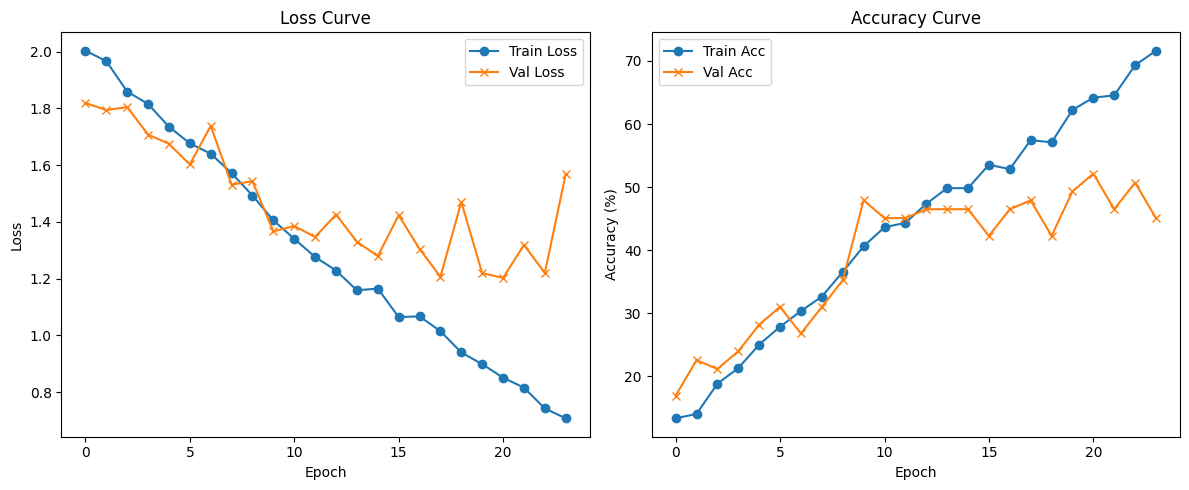

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# --- Label Smoothing Loss ---
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.kl_div = nn.KLDivLoss(reduction='batchmean')

    def forward(self, pred, target):
        pred = torch.log_softmax(pred, dim=-1)
        true_dist = torch.zeros_like(pred)
        true_dist.fill_(self.smoothing / (self.cls - 1))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return self.kl_div(pred, true_dist)

# Setup
num_classes = 11
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TwoBranchSwinDarkNetBiLSTM(num_classes=num_classes).to(device)

# --- Loss, Optimizer, Scheduler ---
criterion = LabelSmoothingLoss(classes=num_classes, smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# AMP scaler
scaler = torch.cuda.amp.GradScaler()

# Early Stopping
patience = 3
best_val_loss = float('inf')
early_stop_counter = 0

# Tracking
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# --- Training Loop ---
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    avg_train_loss = running_train_loss / len(train_loader.dataset)
    train_accuracy = 100. * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # --- Validation ---
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, targets in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]"):
            inputs = inputs.to(device)
            targets = targets.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total_val += targets.size(0)
            correct_val += (predicted == targets).sum().item()

    avg_val_loss = running_val_loss / len(valid_loader.dataset)
    val_accuracy = 100. * correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Logging
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    # Scheduler
    scheduler.step(avg_val_loss)

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

# --- Plotting ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='x')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc', marker='o')
plt.plot(val_accuracies, label='Val Acc', marker='x')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.checkpoint import checkpoint
import timm

torch.backends.cudnn.benchmark = True
torch.cuda.set_per_process_memory_fraction(0.9, device=0)

# --- Group Normalization ---
class GroupNormalization(nn.Module):
    def __init__(self, num_channels, num_groups=8, eps=1e-5):
        super(GroupNormalization, self).__init__()
        self.num_groups = min(num_groups, num_channels)
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(num_channels))
        self.offset = nn.Parameter(torch.zeros(num_channels))

    def forward(self, x):
        N, C = x.size(0), x.size(1)
        G = self.num_groups
        while C % G != 0 and G > 1:
            G -= 1

        if x.dim() == 2:
            x = x.view(N, G, C // G)
            mean = x.mean(dim=2, keepdim=True)
            var = x.var(dim=2, keepdim=True, unbiased=False)
            x = (x - mean) / torch.sqrt(var + self.eps)
            x = x.view(N, C)
        elif x.dim() == 4:
            H, W = x.size(2), x.size(3)
            x = x.view(N, G, C // G, H, W)
            mean = x.mean(dim=[2, 3, 4], keepdim=True)
            var = x.var(dim=[2, 3, 4], keepdim=True, unbiased=False)
            x = (x - mean) / torch.sqrt(var + self.eps)
            x = x.view(N, C, H, W)

        return x * self.scale.view(1, -1, *([1] * (x.dim() - 2))) + \
               self.offset.view(1, -1, *([1] * (x.dim() - 2)))

# --- Model Definition ---
class TwoBranchViTDarkNetBiLSTM(nn.Module):
    def __init__(self, num_classes):
        super(TwoBranchViTDarkNetBiLSTM, self).__init__()

        # Vision Transformer
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.vit.head = nn.Identity()
        for param in self.vit.parameters():
            param.requires_grad = False
        for param in self.vit.blocks[-2:].parameters():
            param.requires_grad = True

        # DarkNet
        self.darknet = timm.create_model("darknet53", pretrained=True, features_only=True)
        
        # Freeze everything (safe)
        for param in self.darknet.parameters():
            param.requires_grad = False
        
        # Workaround: unfreeze parameters from the output feature layer
        # FeatureListNet's __call__() internally uses a list of modules returned by self.children()
        # Let's unfreeze the last child module
        last_module = list(self.darknet.children())[-1]
        for param in last_module.parameters():
            param.requires_grad = True





        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.vit_out_features = self.vit.num_features
        self.darknet_out_features = self.darknet.feature_info[-1]['num_chs']

        self.gn_vit = GroupNormalization(self.vit_out_features, 8)
        self.gn_darknet = GroupNormalization(self.darknet_out_features, 8)
        self.dropout = nn.Dropout(0.5)

        self.lstm_input_size = self.vit_out_features + self.darknet_out_features
        self.lstm_hidden_size = 384
        self.lstm_layers = 3
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_size,
            hidden_size=self.lstm_hidden_size,
            num_layers=self.lstm_layers,
            batch_first=True,
            dropout=0.3,
            bidirectional=True
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            GroupNormalization(num_channels=self.lstm_hidden_size * 2, num_groups=8),
            nn.Linear(self.lstm_hidden_size * 2, 256),
            nn.ReLU(),
            GroupNormalization(256, 8),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            GroupNormalization(128, 8),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 1, 4, 2, 3)  # (B, T, C, H, W)
        B, T, C, H, W = x.shape
        all_features = []

        for t in range(T):
            x_t = x[:, t, :, :, :]

            vit_out = self.vit(x_t)
            vit_out = self.gn_vit(vit_out)

            darknet_feats = self.darknet(x_t)[-1]
            darknet_out = self.global_avg_pool(darknet_feats).squeeze(-1).squeeze(-1)
            darknet_out = self.gn_darknet(darknet_out)

            combined = torch.cat([vit_out, darknet_out], dim=1)
            combined = self.dropout(combined)
            all_features.append(combined)

        all_features = torch.stack(all_features, dim=1)
        lstm_out, _ = self.lstm(all_features)
        lstm_out = lstm_out[:, -1, :]
        output = self.fc(lstm_out)
        return output

# --- Training Setup ---
if __name__ == "__main__":
    num_classes = 11
    model = TwoBranchViTDarkNetBiLSTM(num_classes)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    class_weights = torch.tensor([1.0] * num_classes).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-6)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=2, verbose=True)

    scaler = torch.cuda.amp.GradScaler()

    data_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Dummy input
    input_shape = (16, 16, 224, 224, 3)
    x = torch.randn(input_shape).to(device)
    y = torch.randint(0, num_classes, (input_shape[0],)).to(device)

    with torch.cuda.amp.autocast():
        output = model(x)
        print("Output shape:", output.shape)
        loss = criterion(output, y)
        print("Loss:", loss.item())

    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    scheduler.step(loss)

    torch.cuda.empty_cache()
    del x, y, output, loss


/tmp/ipykernel_35/3239517755.py:146: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_35/3239517755.py:161: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Output shape: torch.Size([16, 11])
Loss: 2.45989990234375


/tmp/ipykernel_35/510124999.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Correct initialization
Epoch 1/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]/tmp/ipykernel_35/510124999.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 [Valid]:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_35/510124999.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 [Valid]: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


Epoch 1 | Train Loss: 2.3794 | Train Acc: 18.79% | Val Loss: 2.0414 | Val Acc: 28.17%


Epoch 2/50 [Valid]: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


Epoch 2 | Train Loss: 1.9572 | Train Acc: 37.06% | Val Loss: 1.6472 | Val Acc: 40.85%


Epoch 3/50 [Valid]: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


Epoch 3 | Train Loss: 1.5155 | Train Acc: 54.26% | Val Loss: 1.5282 | Val Acc: 46.48%


Epoch 4/50 [Valid]: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


Epoch 4 | Train Loss: 1.2527 | Train Acc: 63.12% | Val Loss: 1.2838 | Val Acc: 54.93%


Epoch 5/50 [Valid]: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


Epoch 5 | Train Loss: 1.0332 | Train Acc: 71.10% | Val Loss: 1.1582 | Val Acc: 63.38%


Epoch 6/50 [Valid]: 100%|██████████| 5/5 [00:09<00:00,  1.98s/it]


Epoch 6 | Train Loss: 0.8022 | Train Acc: 82.45% | Val Loss: 1.1976 | Val Acc: 59.15%


Epoch 7/50 [Valid]: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


Epoch 7 | Train Loss: 0.6368 | Train Acc: 87.23% | Val Loss: 1.1107 | Val Acc: 66.20%


Epoch 8/50 [Valid]: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


Epoch 8 | Train Loss: 0.5020 | Train Acc: 93.26% | Val Loss: 0.9039 | Val Acc: 76.06%


Epoch 9/50 [Valid]: 100%|██████████| 5/5 [00:09<00:00,  1.99s/it]


Epoch 9 | Train Loss: 0.3652 | Train Acc: 97.16% | Val Loss: 0.8591 | Val Acc: 74.65%


Epoch 10/50 [Valid]: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


Epoch 10 | Train Loss: 0.2868 | Train Acc: 98.40% | Val Loss: 0.9005 | Val Acc: 73.24%


Epoch 11/50 [Valid]: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


Epoch 11 | Train Loss: 0.2344 | Train Acc: 98.58% | Val Loss: 0.9138 | Val Acc: 76.06%


Epoch 12/50 [Valid]: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


Epoch 12 | Train Loss: 0.1737 | Train Acc: 99.65% | Val Loss: 1.0112 | Val Acc: 73.24%
Early stopping triggered.


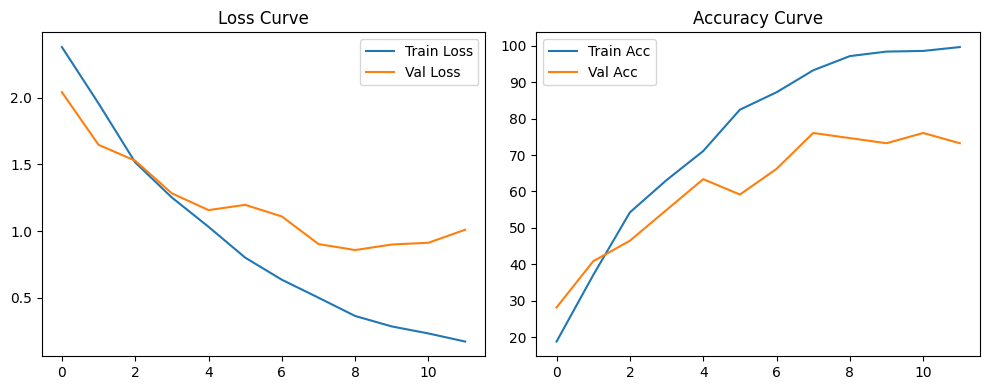

In [25]:
## Merge solve

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Setup
num_classes = 11
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TwoBranchViTDarkNetBiLSTM(num_classes=num_classes).to(device)

# Loss, optimizer, scheduler
class_weights = torch.tensor([1.0] * num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Mixed Precision
scaler = torch.cuda.amp.GradScaler()  # Correct initialization

# Early stopping
patience = 3
best_val_loss = float('inf')
early_stop_counter = 0

# Tracking
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Dataloaders (You must define train_loader, valid_loader before this)
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        inputs = inputs.to(device)  # Regular tensor transfer
        targets = targets.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()

        torch.cuda.empty_cache()

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, targets in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]"):
            inputs = inputs.to(device)
            targets = targets.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

            torch.cuda.empty_cache()

    val_loss /= len(valid_loader.dataset)
    val_accuracy = 100. * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

# Plotting results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy Curve')
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
from sklearn.metrics import accuracy_score
import torch
from tqdm import tqdm

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(inputs)

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {acc * 100:.2f}%")
    return acc


In [27]:
# Assume you already have a test DataLoader
# Example: test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluate on test set
test_accuracy = evaluate_model(model, test_loader, device)


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_35/513499592.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it]

Test Accuracy: 73.24%


In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.checkpoint import checkpoint
import timm

torch.backends.cudnn.benchmark = True
torch.cuda.set_per_process_memory_fraction(0.9, device=0)

# --- Group Normalization ---
class GroupNormalization(nn.Module):
    def __init__(self, num_channels, num_groups=8, eps=1e-5):
        super(GroupNormalization, self).__init__()
        self.num_groups = min(num_groups, num_channels)
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(num_channels))
        self.offset = nn.Parameter(torch.zeros(num_channels))

    def forward(self, x):
        N, C = x.size(0), x.size(1)
        G = self.num_groups
        while C % G != 0 and G > 1:
            G -= 1

        if x.dim() == 2:
            x = x.view(N, G, C // G)
            mean = x.mean(dim=2, keepdim=True)
            var = x.var(dim=2, keepdim=True, unbiased=False)
            x = (x - mean) / torch.sqrt(var + self.eps)
            x = x.view(N, C)
        elif x.dim() == 4:
            H, W = x.size(2), x.size(3)
            x = x.view(N, G, C // G, H, W)
            mean = x.mean(dim=[2, 3, 4], keepdim=True)
            var = x.var(dim=[2, 3, 4], keepdim=True, unbiased=False)
            x = (x - mean) / torch.sqrt(var + self.eps)
            x = x.view(N, C, H, W)

        return x * self.scale.view(1, -1, *([1] * (x.dim() - 2))) + \
               self.offset.view(1, -1, *([1] * (x.dim() - 2)))


# --- Diffusion Encoder (DiT-like block) ---
class DiffusionEncoder(nn.Module):
    def __init__(self, out_features=768):
        super(DiffusionEncoder, self).__init__()
        # Using timm's vision transformer as proxy diffusion encoder
        self.encoder = timm.create_model('vit_small_patch16_224', pretrained=True)
        self.encoder.head = nn.Identity()
        self.out_features = self.encoder.num_features

        # Optional projection to desired dimension
        if self.out_features != out_features:
            self.project = nn.Linear(self.out_features, out_features)
        else:
            self.project = nn.Identity()

    def forward(self, x):
        x = self.encoder(x)
        x = self.project(x)
        return x

# --- Modified Main Model ---
class TwoBranchViTDarkNetDiffusionBiLSTM(nn.Module):
    def __init__(self, num_classes):
        super(TwoBranchViTDarkNetDiffusionBiLSTM, self).__init__()

        # ViT Branch
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.vit.head = nn.Identity()
        for param in self.vit.parameters():
            param.requires_grad = False
        for param in self.vit.blocks[-2:].parameters():
            param.requires_grad = True

        # DarkNet Branch
        self.darknet = timm.create_model("darknet53", pretrained=True, features_only=True)
        for param in self.darknet.parameters():
            param.requires_grad = False
        for param in list(self.darknet.children())[-1].parameters():
            param.requires_grad = True

        # Diffusion Encoder Branch
        self.diffusion_encoder = DiffusionEncoder(out_features=512)

        # Global Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Feature Normalizations
        self.gn_vit = GroupNormalization(self.vit.num_features, 8)
        self.gn_darknet = GroupNormalization(self.darknet.feature_info[-1]['num_chs'], 8)
        self.gn_diff = GroupNormalization(512, 8)

        # Combined LSTM Features
        self.lstm_input_size = self.vit.num_features + self.darknet.feature_info[-1]['num_chs'] + 512
        self.lstm_hidden_size = 384
        self.lstm_layers = 3
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_size,
            hidden_size=self.lstm_hidden_size,
            num_layers=self.lstm_layers,
            batch_first=True,
            dropout=0.3,
            bidirectional=True
        )

        # Final Classifier Head
        self.fc = nn.Sequential(
            nn.Flatten(),
            GroupNormalization(self.lstm_hidden_size * 2, 8),
            nn.Linear(self.lstm_hidden_size * 2, 256),
            nn.ReLU(),
            GroupNormalization(256, 8),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            GroupNormalization(128, 8),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 1, 4, 2, 3)  # (B, T, C, H, W)
        B, T, C, H, W = x.shape
        all_features = []

        for t in range(T):
            x_t = x[:, t, :, :, :]

            # ViT Feature
            vit_out = self.vit(x_t)
            vit_out = self.gn_vit(vit_out)

            # DarkNet Feature
            darknet_feats = self.darknet(x_t)[-1]
            darknet_out = self.global_avg_pool(darknet_feats).squeeze(-1).squeeze(-1)
            darknet_out = self.gn_darknet(darknet_out)

            # Diffusion Encoder Feature
            diff_out = self.diffusion_encoder(x_t)
            diff_out = self.gn_diff(diff_out)

            # Combine Features
            combined = torch.cat([vit_out, darknet_out, diff_out], dim=1)
            all_features.append(combined)

        all_features = torch.stack(all_features, dim=1)  # (B, T, C_combined)
        lstm_out, _ = self.lstm(all_features)
        lstm_out = lstm_out[:, -1, :]
        output = self.fc(lstm_out)
        return output

# --- Training Setup ---
if __name__ == "__main__":
    num_classes = 11
    model = TwoBranchViTDarkNetDiffusionBiLSTM(num_classes)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    class_weights = torch.tensor([1.0] * num_classes).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-6)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=2, verbose=True)

    scaler = torch.cuda.amp.GradScaler()

    data_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Dummy input
    input_shape = (16, 16, 224, 224, 3)
    x = torch.randn(input_shape).to(device)
    y = torch.randint(0, num_classes, (input_shape[0],)).to(device)

    with torch.cuda.amp.autocast():
        output = model(x)
        print("Output shape:", output.shape)
        loss = criterion(output, y)
        print("Loss:", loss.item())

    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    scheduler.step(loss)

    torch.cuda.empty_cache()
    del x, y, output, loss


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_35/2832322619.py:167: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_35/2832322619.py:182: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Output shape: torch.Size([16, 11])
Loss: 3.02874755859375


/tmp/ipykernel_35/1545268195.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Correct initialization
Epoch 1/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]/tmp/ipykernel_35/1545268195.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 [Valid]:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_35/1545268195.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 [Valid]: 100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


Epoch 1 | Train Loss: 2.3787 | Train Acc: 19.33% | Val Loss: 1.8463 | Val Acc: 42.25%


Epoch 2/50 [Valid]: 100%|██████████| 5/5 [00:11<00:00,  2.38s/it]


Epoch 2 | Train Loss: 1.7641 | Train Acc: 42.02% | Val Loss: 1.4228 | Val Acc: 52.11%


Epoch 3/50 [Valid]: 100%|██████████| 5/5 [00:11<00:00,  2.38s/it]


Epoch 3 | Train Loss: 1.3631 | Train Acc: 57.80% | Val Loss: 1.4067 | Val Acc: 60.56%


Epoch 4/50 [Valid]: 100%|██████████| 5/5 [00:11<00:00,  2.38s/it]


Epoch 4 | Train Loss: 1.0948 | Train Acc: 70.21% | Val Loss: 1.2042 | Val Acc: 61.97%


Epoch 5/50 [Valid]: 100%|██████████| 5/5 [00:11<00:00,  2.38s/it]


Epoch 5 | Train Loss: 0.8501 | Train Acc: 80.32% | Val Loss: 1.1505 | Val Acc: 59.15%


Epoch 6/50 [Valid]: 100%|██████████| 5/5 [00:11<00:00,  2.38s/it]


Epoch 6 | Train Loss: 0.5994 | Train Acc: 89.36% | Val Loss: 0.9677 | Val Acc: 70.42%


Epoch 7/50 [Valid]: 100%|██████████| 5/5 [00:11<00:00,  2.38s/it]


Epoch 7 | Train Loss: 0.4211 | Train Acc: 95.74% | Val Loss: 1.0151 | Val Acc: 70.42%


Epoch 8/50 [Valid]: 100%|██████████| 5/5 [00:11<00:00,  2.38s/it]


Epoch 8 | Train Loss: 0.2927 | Train Acc: 98.94% | Val Loss: 0.8940 | Val Acc: 77.46%


Epoch 9/50 [Valid]: 100%|██████████| 5/5 [00:11<00:00,  2.38s/it]


Epoch 9 | Train Loss: 0.2201 | Train Acc: 98.94% | Val Loss: 0.9337 | Val Acc: 73.24%


Epoch 10/50 [Valid]: 100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


Epoch 10 | Train Loss: 0.1761 | Train Acc: 99.47% | Val Loss: 0.9347 | Val Acc: 74.65%


Epoch 11/50 [Valid]: 100%|██████████| 5/5 [00:12<00:00,  2.40s/it]


Epoch 11 | Train Loss: 0.1406 | Train Acc: 99.82% | Val Loss: 0.9477 | Val Acc: 71.83%
Early stopping triggered.


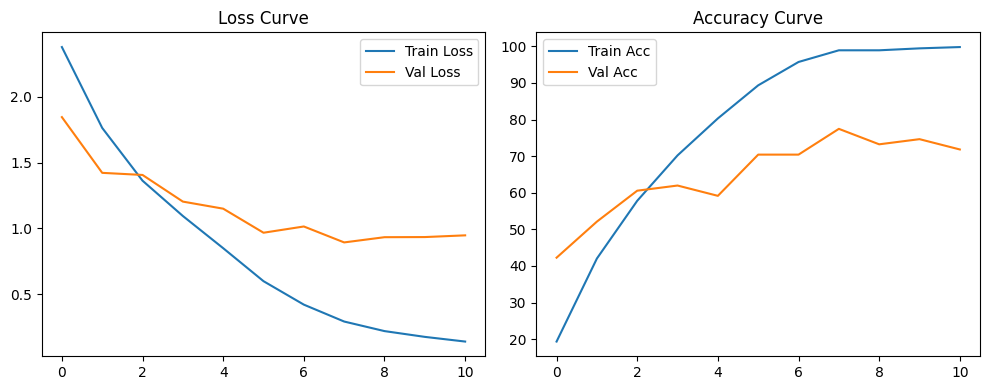

In [46]:
## Merge solve

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Setup
num_classes = 11
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TwoBranchViTDarkNetDiffusionBiLSTM(num_classes=num_classes).to(device)

# Loss, optimizer, scheduler
class_weights = torch.tensor([1.0] * num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Mixed Precision
scaler = torch.cuda.amp.GradScaler()  # Correct initialization

# Early stopping
patience = 3
best_val_loss = float('inf')
early_stop_counter = 0

# Tracking
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Dataloaders (You must define train_loader, valid_loader before this)
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        inputs = inputs.to(device)  # Regular tensor transfer
        targets = targets.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()

        torch.cuda.empty_cache()

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, targets in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]"):
            inputs = inputs.to(device)
            targets = targets.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

            torch.cuda.empty_cache()

    val_loss /= len(valid_loader.dataset)
    val_accuracy = 100. * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

# Plotting results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy Curve')
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.checkpoint import checkpoint
import timm

torch.backends.cudnn.benchmark = True
torch.cuda.set_per_process_memory_fraction(0.9, device=0)

# --- Group Normalization ---
class GroupNormalization(nn.Module):
    def __init__(self, num_channels, num_groups=8, eps=1e-5):
        super(GroupNormalization, self).__init__()
        self.num_groups = min(num_groups, num_channels)
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(num_channels))
        self.offset = nn.Parameter(torch.zeros(num_channels))

    def forward(self, x):
        N, C = x.size(0), x.size(1)
        G = self.num_groups
        while C % G != 0 and G > 1:
            G -= 1

        if x.dim() == 2:
            x = x.view(N, G, C // G)
            mean = x.mean(dim=2, keepdim=True)
            var = x.var(dim=2, keepdim=True, unbiased=False)
            x = (x - mean) / torch.sqrt(var + self.eps)
            x = x.view(N, C)
        elif x.dim() == 4:
            H, W = x.size(2), x.size(3)
            x = x.view(N, G, C // G, H, W)
            mean = x.mean(dim=[2, 3, 4], keepdim=True)
            var = x.var(dim=[2, 3, 4], keepdim=True, unbiased=False)
            x = (x - mean) / torch.sqrt(var + self.eps)
            x = x.view(N, C, H, W)

        return x * self.scale.view(1, -1, *([1] * (x.dim() - 2))) + \
               self.offset.view(1, -1, *([1] * (x.dim() - 2)))

# --- Model Definition ---
class TwoBranchSwinDarkNetLSTM(nn.Module):
    def __init__(self, num_classes):
        super(TwoBranchSwinDarkNetLSTM, self).__init__()

        # Swin Transformer branch
        swin = models.swin_t(weights=models.Swin_T_Weights.DEFAULT)
        self.swin_features = nn.Sequential(*list(swin.children())[:-2])
        for param in self.swin_features.parameters():
            param.requires_grad = False
        for module in list(self.swin_features)[-2:]:
            for param in module.parameters():
                param.requires_grad = True

        # DarkNet from timm
        darknet = timm.create_model("darknet53", pretrained=True, features_only=True)
        self.darknet_features = darknet
        
        # Freeze all layers first
        for param in self.darknet_features.parameters():
            param.requires_grad = False
            
        # Enable training for the last convolutional layer's parameters
        # For DarkNet in timm with features_only=True, we need to access the last block differently
        # Get the last feature block's children and unfreeze them
        last_block = list(self.darknet_features.children())[-1]
        for param in last_block.parameters():
            param.requires_grad = True

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.swin_out_features = 768
        self.darknet_out_features = self.darknet_features.feature_info[-1]['num_chs']

        self.gn_swin = GroupNormalization(num_channels=self.swin_out_features, num_groups=8)
        self.gn_darknet = GroupNormalization(num_channels=self.darknet_out_features, num_groups=8)
        self.dropout = nn.Dropout(0.5)

        self.lstm_input_size = self.swin_out_features + self.darknet_out_features
        self.lstm_hidden_size = 256
        self.lstm_layers = 4
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_size,
            hidden_size=self.lstm_hidden_size,
            num_layers=self.lstm_layers,
            batch_first=True,
            dropout=0.4,
            bidirectional=False
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            GroupNormalization(num_channels=self.lstm_hidden_size, num_groups=8),
            nn.Linear(self.lstm_hidden_size, 128),
            nn.ReLU(),
            GroupNormalization(num_channels=128, num_groups=8),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            GroupNormalization(num_channels=64, num_groups=8),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 1, 4, 2, 3)  # (B, T, C, H, W)
        B, T, C, H, W = x.shape

        all_features = []
        for t in range(T):
            x_t = x[:, t, :, :, :]

            swin_out = checkpoint(self.swin_features, x_t)
            swin_out = self.global_avg_pool(swin_out).squeeze(-1).squeeze(-1)
            swin_out = self.gn_swin(swin_out)

            darknet_feats = self.darknet_features(x_t)[-1]
            darknet_out = self.global_avg_pool(darknet_feats).squeeze(-1).squeeze(-1)
            darknet_out = self.gn_darknet(darknet_out)

            combined = torch.cat([swin_out, darknet_out], dim=1)
            combined = self.dropout(combined)
            all_features.append(combined)

        all_features = torch.stack(all_features, dim=1)  # (B, T, F)
        lstm_out, _ = self.lstm(all_features)
        lstm_out = lstm_out[:, -1, :]
        output = self.fc(lstm_out)
        return output

# --- Training Setup ---
if __name__ == "__main__":
    num_classes = 11
    model = TwoBranchSwinDarkNetLSTM(num_classes)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    class_weights = torch.tensor([1.0] * num_classes).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-6)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=2, verbose=True)

    scaler = torch.cuda.amp.GradScaler()

    data_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Dummy input for test
    input_shape = (16, 16, 224, 224, 3)
    x = torch.randn(input_shape).to(device)
    y = torch.randint(0, num_classes, (input_shape[0],)).to(device)

    with torch.cuda.amp.autocast():
        output = model(x)
        print("Output shape:", output.shape)
        loss = criterion(output, y)
        print("Loss:", loss.item())

    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    scheduler.step(loss)

    torch.cuda.empty_cache()
    del x, y, output, loss

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_31/3679804109.py:145: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_31/3679804109.py:160: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the diff

Output shape: torch.Size([16, 11])
Loss: 2.53265380859375


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.checkpoint import checkpoint

torch.backends.cudnn.benchmark = True
torch.cuda.set_per_process_memory_fraction(0.9, device=0)

# --- Group Normalization ---
class GroupNormalization(nn.Module):
    def __init__(self, num_channels, num_groups=8, eps=1e-5):
        super(GroupNormalization, self).__init__()
        self.num_groups = min(num_groups, num_channels)
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(num_channels))
        self.offset = nn.Parameter(torch.zeros(num_channels))

    def forward(self, x):
        N, C = x.size(0), x.size(1)
        G = self.num_groups
        while C % G != 0 and G > 1:
            G -= 1

        if x.dim() == 2:
            x = x.view(N, G, C // G)
            mean = x.mean(dim=2, keepdim=True)
            var = x.var(dim=2, keepdim=True, unbiased=False)
            x = (x - mean) / torch.sqrt(var + self.eps)
            x = x.view(N, C)
        elif x.dim() == 4:
            H, W = x.size(2), x.size(3)
            x = x.view(N, G, C // G, H, W)
            mean = x.mean(dim=[2, 3, 4], keepdim=True)
            var = x.var(dim=[2, 3, 4], keepdim=True, unbiased=False)
            x = (x - mean) / torch.sqrt(var + self.eps)
            x = x.view(N, C, H, W)

        return x * self.scale.view(1, -1, *([1] * (x.dim() - 2))) + \
               self.offset.view(1, -1, *([1] * (x.dim() - 2)))

# --- Model Definition ---
class TwoBranchSwinDenseNetLSTM(nn.Module):
    def __init__(self, num_classes):
        super(TwoBranchSwinDenseNetLSTM, self).__init__()

        swin = models.swin_t(weights=models.Swin_T_Weights.DEFAULT)
        self.swin_features = nn.Sequential(*list(swin.children())[:-2])
        for param in self.swin_features.parameters():
            param.requires_grad = False
        for module in list(self.swin_features)[-2:]:
            for param in module.parameters():
                param.requires_grad = True

        densenet = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        self.densenet_features = densenet.features
        for param in self.densenet_features.parameters():
            param.requires_grad = False
        for module in list(self.densenet_features.children())[-6:]:
            for param in module.parameters():
                param.requires_grad = True

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.swin_out_features = 768
        self.densenet_out_features = 1024

        self.gn_swin = GroupNormalization(num_channels=self.swin_out_features, num_groups=8)
        self.gn_densenet = GroupNormalization(num_channels=self.densenet_out_features, num_groups=8)
        self.dropout = nn.Dropout(0.5)

        self.lstm_input_size = self.swin_out_features + self.densenet_out_features
        self.lstm_hidden_size = 256
        self.lstm_layers = 4  # Made deeper
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_size,
            hidden_size=self.lstm_hidden_size,
            num_layers=self.lstm_layers,
            batch_first=True,
            dropout=0.4,
            bidirectional=False
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            GroupNormalization(num_channels=self.lstm_hidden_size, num_groups=8),
            nn.Linear(self.lstm_hidden_size, 128),
            nn.ReLU(),
            GroupNormalization(num_channels=128, num_groups=8),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            GroupNormalization(num_channels=64, num_groups=8),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 1, 4, 2, 3)  # (B, T, C, H, W)
        B, T, C, H, W = x.shape

        all_features = []
        for t in range(T):
            x_t = x[:, t, :, :, :]

            swin_out = checkpoint(self.swin_features, x_t)
            swin_out = self.global_avg_pool(swin_out).squeeze(-1).squeeze(-1)
            swin_out = self.gn_swin(swin_out)

            densenet_out = checkpoint(self.densenet_features, x_t)
            densenet_out = self.global_avg_pool(densenet_out).squeeze(-1).squeeze(-1)
            densenet_out = self.gn_densenet(densenet_out)

            combined = torch.cat([swin_out, densenet_out], dim=1)
            combined = self.dropout(combined)
            all_features.append(combined)

        all_features = torch.stack(all_features, dim=1)  # (B, T, F)
        lstm_out, _ = self.lstm(all_features)
        lstm_out = lstm_out[:, -1, :]  # Use last hidden state
        output = self.fc(lstm_out)
        return output

# --- Training Setup ---
if __name__ == "__main__":
    num_classes = 11
    model = TwoBranchSwinDenseNetLSTM(num_classes)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    class_weights = torch.tensor([1.0] * num_classes).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-6)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=2, verbose=True)

    scaler = torch.cuda.amp.GradScaler()

    data_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Dummy input for test
    input_shape = (16, 16, 224, 224, 3)
    x = torch.randn(input_shape).to(device)
    y = torch.randint(0, num_classes, (input_shape[0],)).to(device)

    with torch.cuda.amp.autocast():
        output = model(x)
        print("Output shape:", output.shape)
        loss = criterion(output, y)
        print("Loss:", loss.item())

    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    scheduler.step(loss)

    torch.cuda.empty_cache()
    del x, y, output, loss


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_31/4274448319.py:136: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_31/4274448319.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Output shape: torch.Size([16, 11])
Loss: 2.9163818359375


/tmp/ipykernel_31/486452347.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Correct initialization
Epoch 1/50 [Train]:   0%|          | 0/36 [00:00<?, ?it/s]/tmp/ipykernel_31/486452347.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 [Valid]:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_31/486452347.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


Epoch 1 | Train Loss: 2.5745 | Train Acc: 11.52% | Val Loss: 2.3023 | Val Acc: 16.90%


Epoch 2/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Epoch 2 | Train Loss: 2.3946 | Train Acc: 18.26% | Val Loss: 2.2430 | Val Acc: 21.13%


Epoch 3/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Epoch 3 | Train Loss: 2.2703 | Train Acc: 25.53% | Val Loss: 2.1325 | Val Acc: 23.94%


Epoch 4/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Epoch 4 | Train Loss: 2.1154 | Train Acc: 30.67% | Val Loss: 1.9499 | Val Acc: 25.35%


Epoch 5/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Epoch 5 | Train Loss: 1.8703 | Train Acc: 40.43% | Val Loss: 1.8422 | Val Acc: 39.44%


Epoch 6/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Epoch 6 | Train Loss: 1.7567 | Train Acc: 45.39% | Val Loss: 1.8625 | Val Acc: 38.03%


Epoch 7/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]


Epoch 7 | Train Loss: 1.5862 | Train Acc: 50.89% | Val Loss: 1.6134 | Val Acc: 43.66%


Epoch 8/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Epoch 8 | Train Loss: 1.4794 | Train Acc: 55.50% | Val Loss: 1.5812 | Val Acc: 47.89%


Epoch 9/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Epoch 9 | Train Loss: 1.3660 | Train Acc: 58.69% | Val Loss: 1.4188 | Val Acc: 49.30%


Epoch 10/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Epoch 10 | Train Loss: 1.2287 | Train Acc: 66.84% | Val Loss: 1.4130 | Val Acc: 60.56%


Epoch 11/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Epoch 11 | Train Loss: 1.0733 | Train Acc: 74.29% | Val Loss: 1.4037 | Val Acc: 56.34%


Epoch 12/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Epoch 12 | Train Loss: 0.9673 | Train Acc: 78.37% | Val Loss: 1.4572 | Val Acc: 52.11%


Epoch 13/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Epoch 13 | Train Loss: 0.8736 | Train Acc: 82.45% | Val Loss: 1.2773 | Val Acc: 64.79%


Epoch 14/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Epoch 14 | Train Loss: 0.7392 | Train Acc: 88.12% | Val Loss: 1.3126 | Val Acc: 56.34%


Epoch 15/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Epoch 15 | Train Loss: 0.6644 | Train Acc: 91.13% | Val Loss: 1.2196 | Val Acc: 64.79%


Epoch 16/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Epoch 16 | Train Loss: 0.6182 | Train Acc: 92.73% | Val Loss: 1.4082 | Val Acc: 59.15%


Epoch 17/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Epoch 17 | Train Loss: 0.5884 | Train Acc: 92.02% | Val Loss: 1.3714 | Val Acc: 56.34%


Epoch 18/50 [Valid]: 100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Epoch 18 | Train Loss: 0.4753 | Train Acc: 96.45% | Val Loss: 1.4100 | Val Acc: 57.75%
Early stopping triggered.


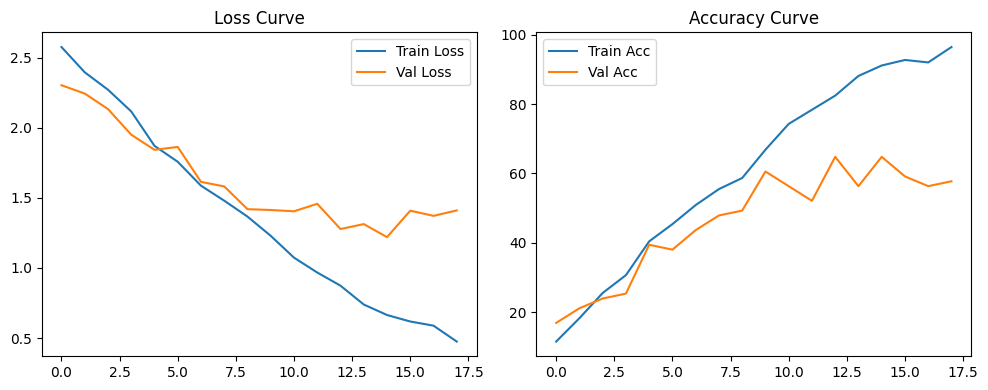

In [25]:
## Merge solve

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Setup
num_classes = 11
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TwoBranchSwinDarkNetLSTM(num_classes=num_classes).to(device)

# Loss, optimizer, scheduler
class_weights = torch.tensor([1.0] * num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Mixed Precision
scaler = torch.cuda.amp.GradScaler()  # Correct initialization

# Early stopping
patience = 3
best_val_loss = float('inf')
early_stop_counter = 0

# Tracking
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Dataloaders (You must define train_loader, valid_loader before this)
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        inputs = inputs.to(device)  # Regular tensor transfer
        targets = targets.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()

        torch.cuda.empty_cache()

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, targets in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]"):
            inputs = inputs.to(device)
            targets = targets.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

            torch.cuda.empty_cache()

    val_loss /= len(valid_loader.dataset)
    val_accuracy = 100. * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

# Plotting results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy Curve')
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim

# Lightweight Fire Module
class FireModule(nn.Module):
    def __init__(self, in_channels, squeeze_channels, expand_channels):
        super(FireModule, self).__init__()
        self.squeeze = nn.Sequential(
            nn.Conv2d(in_channels, squeeze_channels, kernel_size=1),
            nn.BatchNorm2d(squeeze_channels),
            nn.ReLU(inplace=True)
        )
        self.expand1x1 = nn.Sequential(
            nn.Conv2d(squeeze_channels, expand_channels, kernel_size=1),
            nn.BatchNorm2d(expand_channels),
            nn.ReLU(inplace=True)
        )
        self.expand3x3 = nn.Sequential(
            nn.Conv2d(squeeze_channels, expand_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(expand_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.squeeze(x)
        return torch.cat([self.expand1x1(x), self.expand3x3(x)], dim=1)

# Custom Transformer Encoder
class CustomTransformer(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim, dropout=0.1):
        super(CustomTransformer, self).__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=hidden_dim,
                dropout=dropout,
                batch_first=True
            ),
            num_layers=1
        )

    def forward(self, x):
        return self.encoder(x)

# Lightweight Video Classifier
class LightweightVideoClassifier(nn.Module):
    def __init__(self, num_classes):
        super(LightweightVideoClassifier, self).__init__()

        self.cnn_stack = nn.Sequential(
            FireModule(3, 8, 16),         # Output channels: 32
            nn.MaxPool2d(2),              # 112x112
            FireModule(32, 8, 16),        # Output channels: 32
            nn.MaxPool2d(2),              # 56x56
            nn.AdaptiveAvgPool2d((2, 2))  # Output: (B, 32, 2, 2)
        )

        self.cnn_output_dim = 32 * 2 * 2  # 128

        self.embedding_proj = nn.Conv2d(3, 32, kernel_size=4, stride=4)  # (B, 32, 56, 56)
        self.custom_transformer = CustomTransformer(embed_dim=32, num_heads=2, hidden_dim=64)

        self.transformer_fc = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(64)
        )

        self.gru_input_dim = self.cnn_output_dim + 64
        self.gru = nn.GRU(input_size=self.gru_input_dim, hidden_size=64, num_layers=1, batch_first=True)

        self.classifier = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 1, 4, 2, 3)  # (B, T, C, H, W)
        B, T, C, H, W = x.shape
        features = []

        for t in range(T):
            x_t = x[:, t]  # (B, C, H, W)

            # CNN Path
            cnn_out = self.cnn_stack(x_t)
            cnn_feat = cnn_out.reshape(B, -1)  # (B, 128)

            # Transformer Path
            trans_in = self.embedding_proj(x_t)        # (B, 32, 56, 56)
            trans_seq = trans_in.flatten(2).transpose(1, 2)  # (B, N, 32)
            trans_feat = self.custom_transformer(trans_seq)
            trans_feat = trans_feat.mean(dim=1)        # (B, 32)
            trans_feat = self.transformer_fc(trans_feat)  # (B, 64)

            combined = torch.cat([cnn_feat, trans_feat], dim=1)  # (B, 192)
            features.append(combined)

        features = torch.stack(features, dim=1)  # (B, T, D)
        gru_out, _ = self.gru(features)          # (B, T, 64)
        out = gru_out[:, -1]                     # Last timestep
        return self.classifier(out)

# Setup
num_classes = 11
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LightweightVideoClassifier(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Dummy test - Batch size 16, Frame rate 16, Input resolution 224x224
with torch.no_grad():
    x = torch.randn(16, 16, 224, 224, 3).to(device)  # (B=16, T=16, H, W, C)
    y = torch.randint(0, num_classes, (16,)).to(device)
    output = model(x)
    print("Output shape:", output.shape)
    loss = criterion(output, y)
    print("Loss:", loss.item())


Output shape: torch.Size([16, 11])
Loss: 2.366361379623413


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Setup
num_classes = 11
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LightweightVideoClassifier(num_classes=num_classes).to(device)

# Loss, optimizer, scheduler
class_weights = torch.tensor([1.0] * num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Mixed Precision
scaler = torch.cuda.amp.GradScaler()

# Early stopping
patience = 3
best_val_loss = float('inf')
early_stop_counter = 0

# Tracking
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# You must define train_loader and valid_loader before running
# Example:
# train_loader = ...
# valid_loader = ...

# Dataloaders (assumed to be already defined)
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        inputs = inputs.to(device, memory_format=torch.channels_last)
        targets = targets.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()

        torch.cuda.empty_cache()

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, targets in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]"):
            inputs = inputs.to(device, memory_format=torch.channels_last)
            targets = targets.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

            torch.cuda.empty_cache()

    val_loss /= len(valid_loader.dataset)
    val_accuracy = 100. * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

# Plotting results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy Curve')
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_31/458990669.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/50 [Train]:   0%|          | 0/36 [00:01<?, ?it/s]


RuntimeError: required rank 4 tensor to use channels_last format

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Lightweight Fire Module
class FireModule(nn.Module):
    def __init__(self, in_channels, squeeze_channels, expand_channels):
        super(FireModule, self).__init__()
        self.squeeze = nn.Sequential(
            nn.Conv2d(in_channels, squeeze_channels, kernel_size=1),
            nn.BatchNorm2d(squeeze_channels),
            nn.ReLU(inplace=True)
        )
        self.expand1x1 = nn.Sequential(
            nn.Conv2d(squeeze_channels, expand_channels, kernel_size=1),
            nn.BatchNorm2d(expand_channels),
            nn.ReLU(inplace=True)
        )
        self.expand3x3 = nn.Sequential(
            nn.Conv2d(squeeze_channels, expand_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(expand_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.squeeze(x)
        return torch.cat([self.expand1x1(x), self.expand3x3(x)], dim=1)

# Custom Transformer Encoder
class CustomTransformer(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim, dropout=0.1):
        super(CustomTransformer, self).__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=hidden_dim,
                dropout=dropout,
                batch_first=True
            ),
            num_layers=1
        )

    def forward(self, x):
        return self.encoder(x)

# Lightweight Video Classifier
class LightweightVideoClassifier(nn.Module):
    def __init__(self, num_classes):
        super(LightweightVideoClassifier, self).__init__()

        self.cnn_stack = nn.Sequential(
            FireModule(3, 8, 16),         # Output channels: 32
            nn.MaxPool2d(2),              # 112x112
            FireModule(32, 8, 16),        # Output channels: 32
            nn.MaxPool2d(2),              # 56x56
            nn.AdaptiveAvgPool2d((2, 2))  # Output: (B, 32, 2, 2)
        )

        self.cnn_output_dim = 32 * 2 * 2  # 128

        self.embedding_proj = nn.Conv2d(3, 32, kernel_size=4, stride=4)  # (B, 32, 56, 56)
        self.custom_transformer = CustomTransformer(embed_dim=32, num_heads=2, hidden_dim=64)

        self.transformer_fc = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(64)
        )

        self.gru_input_dim = self.cnn_output_dim + 64
        self.gru = nn.GRU(input_size=self.gru_input_dim, hidden_size=64, num_layers=1, batch_first=True)

        self.classifier = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 1, 4, 2, 3)  # (B, T, C, H, W)
        B, T, C, H, W = x.shape
        features = []

        for t in range(T):
            x_t = x[:, t]  # (B, C, H, W)

            # CNN Path
            cnn_out = self.cnn_stack(x_t)
            cnn_feat = cnn_out.reshape(B, -1)  # (B, 128)

            # Transformer Path
            trans_in = self.embedding_proj(x_t)        # (B, 32, 56, 56)
            trans_seq = trans_in.flatten(2).transpose(1, 2)  # (B, N, 32)
            trans_feat = self.custom_transformer(trans_seq)
            trans_feat = trans_feat.mean(dim=1)        # (B, 32)
            trans_feat = self.transformer_fc(trans_feat)  # (B, 64)

            combined = torch.cat([cnn_feat, trans_feat], dim=1)  # (B, 192)
            features.append(combined)

        features = torch.stack(features, dim=1)  # (B, T, D)
        gru_out, _ = self.gru(features)          # (B, T, 64)
        out = gru_out[:, -1]                     # Last timestep
        return self.classifier(out)


# Setup
num_classes = 11
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LightweightVideoClassifier(num_classes=num_classes).to(device)

# Loss, optimizer, scheduler
class_weights = torch.tensor([1.0] * num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Mixed Precision
scaler = torch.cuda.amp.GradScaler()

# Early stopping
patience = 2
best_val_loss = float('inf')
early_stop_counter = 0

# Tracking
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# You must define train_loader and valid_loader before running
# Example:
# train_loader = ...
# valid_loader = ...

# Dataloaders (assumed to be already defined)
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        inputs = inputs.to(device, memory_format=torch.channels_last)
        targets = targets.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()

        torch.cuda.empty_cache()

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, targets in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]"):
            inputs = inputs.to(device, memory_format=torch.channels_last)
            targets = targets.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

            torch.cuda.empty_cache()

    val_loss /= len(valid_loader.dataset)
    val_accuracy = 100. * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

# Plotting results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy Curve')
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_31/2975321264.py:125: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/50 [Train]:   0%|          | 0/36 [00:01<?, ?it/s]


RuntimeError: required rank 4 tensor to use channels_last format

In [13]:
import torch

# Clear cache to free unused memory
torch.cuda.empty_cache()

# Optionally reset memory statistics
torch.cuda.reset_peak_memory_stats()


In [20]:
import torch
import torch.nn as nn
import torchvision.models as models

class DeepSwinBiLSTM(nn.Module):
    def __init__(self, num_classes, sequence_length=5):
        super(DeepSwinBiLSTM, self).__init__()

        self.sequence_length = sequence_length

        # Load Swin Transformer V2 Large from torchvision
        swin = models.swin_v2_l(weights=models.Swin_V2_L_Weights.DEFAULT)

        # Extract feature extractor (excluding classification head)
        self.feature_extractor = nn.Sequential(*list(swin.children())[:-1])

        # Transformer Encoder Layer
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=1536, nhead=8, dim_feedforward=2048, dropout=0.1),
            num_layers=4  # Increase depth of Transformer layers
        )

        # BiLSTM for sequential modeling
        self.bilstm = nn.LSTM(input_size=1536, hidden_size=768, num_layers=3, batch_first=True, bidirectional=True)

        # Fully connected layers with Dropout & BatchNorm
        self.fc_layers = nn.Sequential(
            nn.Linear(768 * 2, 512),  # 768 * 2 for BiLSTM (bidirectional)
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        batch_size, seq_len, C, H, W = x.shape
        assert seq_len == self.sequence_length, f"Expected sequence length {self.sequence_length}, but got {seq_len}"

        # Process each frame through Swin Transformer
        features = []
        for t in range(seq_len):
            frame = x[:, t, :, :, :]  # Extract frame
            feature = self.feature_extractor(frame)  # Get feature representation
            feature = feature.view(batch_size, -1)  # Flatten
            features.append(feature)

        # Stack extracted features along sequence dimension
        features = torch.stack(features, dim=1)  # Shape: (batch_size, seq_len, 1536)

        # Pass through Transformer Encoder
        features = self.transformer(features)  # Shape remains (batch_size, seq_len, 1536)

        # Pass features through BiLSTM
        lstm_out, _ = self.bilstm(features)  # Shape: (batch_size, seq_len, 768*2)

        # Use the last BiLSTM output for classification
        out = self.fc_layers(lstm_out[:, -1, :])  # Shape: (batch_size, num_classes)

        return out

# Define model parameters
num_classes = 19
sequence_length = 5  # Adjust as needed

# Initialize model
model = DeepSwinBiLSTM(num_classes, sequence_length)

# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Print model summary
print(model)

# Sample input tensor (batch_size=2, sequence_length=5, channels=3, height=224, width=224)
sample_input = torch.randn(2, sequence_length, 3, 224, 224).to(device)

# Forward pass test
output = model(sample_input)
print(f"Output shape: {output.shape}")  # Expected: (2, 19)


AttributeError: module 'torchvision.models' has no attribute 'swin_v2_l'